<font size="+10"><center>W203 Statistics for Data Science</font>



<font size="+8"><center>Lab 3: A Regression Study of COVID-19</font>



<font size="+3"><center>Monday, 4 PM</font>



<font size="+3"><center>Summer 2020</font>





<font size="+3"><center>August 2, 2020 </font>



<font size="+3"><center>Mackenzie Lee, Aditya Mengani </font>



## 1. An Introduction

The politicization of COVID-19 has lead to an increase in misinformation about the virus contributing to the increase in cases and deaths. The president of the United States has requested fewer tests stating "with smaller testing we would show fewer cases", logically, but we want to investigate the association between number of deaths and tests with the following question:

**Do states with higher testing have more total deaths?**

Some leaders believe that fewer tests conducted means a smaller number of cases, while other leaders and analysts believe the opposite. Policy making is affected with such beliefs and authorities are not being vigilant by spending less to buy equipment to handle serious illnesses leading to more deaths (like buying more ventilators, ambulances, burial ground spaces,ex-gratia, etc.). We would like to study the relationship between testing and deaths, and use that as a basis for being more vigilant leading to better policy making.

The data contains information on the state level including for the District of Columbia and we will use total deaths as the dependent variable as that is the variable we are interested in measuring. This variable captures the total number of deaths for the state. To address the question, three different model specifications will be used:

1. Total Deaths regressed on Total Test Results

We are interested in this simple regression for the first specification only using the total number of tests without any covariates to isolate the effect of testing on deaths. This will be the simplest specification to address the question.

2. Total Deaths regressed on Total Test Results + Population Density + Percent at risk for serious illness due to COVID

The second model specification adds key covariates based on the contributing factors that could lead to more deaths. We add population density and the percent at risk, since they help capture the spread of the disease as well as the an intuitive measure into those most likely to die. In summary, the addition of these covariates are key variables that capture intuitive knowledge of what can lead to more deaths.

3. Total Deaths regressed on Total Test Results + Population Density + Rate per 100,000 + Cases in last 7 day + Percent living under the federal poverty line (2018) + Days required business close + Children 0-18 + Adults 19-25 + Adults 26-34 + Adults 35-54 + Adults 55-64 + Weekly unemployment insurance maximum amount (dollars) 

We add more variables into the third model specification erring on the side of inclusion. We add more variables that provide additional insight into severity of COVID transmission in a state as well as the number of confirmed cases as these are the precursors to death and give information on the severity of spread. We also add variables about state policy designed to protect people and reduce the risk of exposure as the US experienced lockdowns nationwide to curb infections. Economic measures are a confirmed factor for those who are more susceptible to die from COVID and we add these additional variables as well as population proportions in the same light that the elderly are the most at risk and knowing the population breakdowns for states could provide insight into the number of deaths. 






## 2. A Model Building Process

In [2]:
#import all libraries
library(car)
library(sandwich)
library(lmtest)
library(stargazer)
library(corrplot)
library("readxl") 
library(ggplot2)

Loading required package: carData

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 


corrplot 0.84 loaded



In [3]:
# Reading in the data using R read_excel function
df = read_excel("covid-19_dist0720.xlsx", sheet = "Covid-19",
                      guess_max = 100 ,na = c('0'))

In [4]:
####################### Treatment of Error records ######################
# Identified that there is a duplicate row for Arizona, used the
# web page to identify the accurate row and delete the duplicate row
# by verifying the data through total cases and total death count
# in the below link
# https://www.nytimes.com/interactive/2020/us/arizona-coronavirus-cases.html

df = df[-4,]


In [5]:
################ New variables created ####################################
# created a variable "days_mask" which calculates
# the difference between "2020-07-02" and the date face masks were mandated. We use "2020-07-02" since 
# that date is the referenced date for public policy given in the data set.
# "Mandate face mask use by employees in public-facing businesses"

df$days_mask = as.Date(as.character("2020-07-02"), format="%Y-%m-%d")- 
as.Date(as.character(df$`Mandate face mask use by employees in public-facing businesses`), format="%Y-%m-%d")
df$days_mask = as.numeric(df$days_mask)

# treating the empty/blank value of "End/relax stay at home/shelter 
# in place" to a low 1960-10-01 for caculation purposes instead of 0
# since date cannot be converted to 0 it needs to be a
# default value like 1960-10-01 or 1900-01-01 for calculation purposes
df$`End/relax stay at home/shelter in place`[is.na(df$`End/relax stay at home/shelter in place`)] = as.Date("1960-10-01")

# created variable for No. of days non-essential businesses were closed 
# before reopening "days_business" which is defined as 
# difference between "Began to reopen businesses statewide"
# and "Closed non-essential businesses"
df$days_business = as.Date(as.character(df$`Began to reopen businesses statewide`), format="%Y-%m-%d")- 
                    as.Date(as.character(df$`Closed non-essential businesses`), format="%Y-%m-%d")
df$days_business = as.numeric(df$days_business)

#Calculates the proportion of older populations as a single value
df$elderly = df$`Adults 55-64` + df$`65+`

In [6]:
################ Data Imputations ####################################
# For days_mask variable if there is a blank value, replace with 0
df$days_mask[is.na(df$days_mask)] = 0
#Impute blank values with 0 as we assume those states didn't implement any mandatory mask requirement

#For variable totalTestResults there is a missing value for Kentucky
# state
which(is.na(df$totalTestResults))
# Replacing the missing value with appropriate value by looking into the
# website https://covidtracking.com/data/state/kentucky#historical
# identifying that sum(16376+379271) is the total no. of test results
# for the datasets
df$totalTestResults[is.na(df$totalTestResults)] = 16376 + 379271 

[1] 18

In [7]:
#There are missing values for the age demographics 64 for Ohio
which(is.na( df$"Adults 55-64"))
#Impute with the proper demographic 
#https://www.kff.org/other/state-indicator/distribution-by-age/?currentTimeframe=0&selectedRows
#=%7B%22states%22:%7B%22ohio%22:%7B%7D%7D%7D&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D 
df$"Children 0-18"[is.na(df$"Children 0-18")] = 0.23
df$"Adults 26-34"[is.na(df$"Adults 26-34")] = 0.12
df$"Adults 55-64"[is.na(df$"Adults 55-64")] = 0.14

[1] 36

In [8]:
####### Renaming the column names for ease of coding #####################
names(df)[names(df) 
          == 'Total Death'] = 'deaths'
names(df)[names(df) 
          == 'totalTestResults'] = 'tests'
names(df)[names(df) == 'Percent living under the federal poverty line (2018)'] = 'poverty'
names(df)[names(df) == 
          'Population density per square miles'] = 'density'
names(df)[names(df) == 
          'Weekly unemployment insurance maximum amount (dollars)'] = 'unemployment'
names(df)[names(df) == 
          'Percent at risk for serious illness due to COVID'] = 'risk'
names(df)[names(df) == 
          'CasesInLast7Days'] = 'cases'

############# Creating variables out of df ###########################
death = df$deaths
cases = df$cases
density = df$`density`
risk = df$`risk`
test = df$tests
pov = df$`poverty`
pop = df$density
mask = df$days_mask
bus = df$days_business
rate = df$RatePer100000
unemp = df$`unemployment`
days_mask = df$days_mask
child = df$`Children 0-18`
young_ad = df$`Adults 19-25`
mil_ad = df$`Adults 26-34`
mid_ad = df$`Adults 35-54`
old_ad = df$`Adults 55-64`
elderly = df$elderly
#Note on Age variables(Top-coded): We didnt include a variable 
#for adults for ages 65+ as, if you know the other 5 age groups 
#we can determine the last group from others

We perform the above data imputations for *days_mask* as there are blank values for it and we impute it with 0 for which assumes those states did not implement any requirement. The age demographics for Ohio were also missing values which we imputed with values we looked up with the cited source above. Similarly for *test*, there is a missing value for KY state and we replaced it with an appropriate value by the website cited above.

### Model 1

#### Total Deaths ~ Total Test Results

As part of our model 1 specification we would like to study what relationship does the number of deaths have with the number of test results. As the test results rise or fall, how do the deaths vary for the increase/decrease. 

- ***test*** measures the total number of tests

Below is the detailed EDA and transformations that were applied for the model specification:

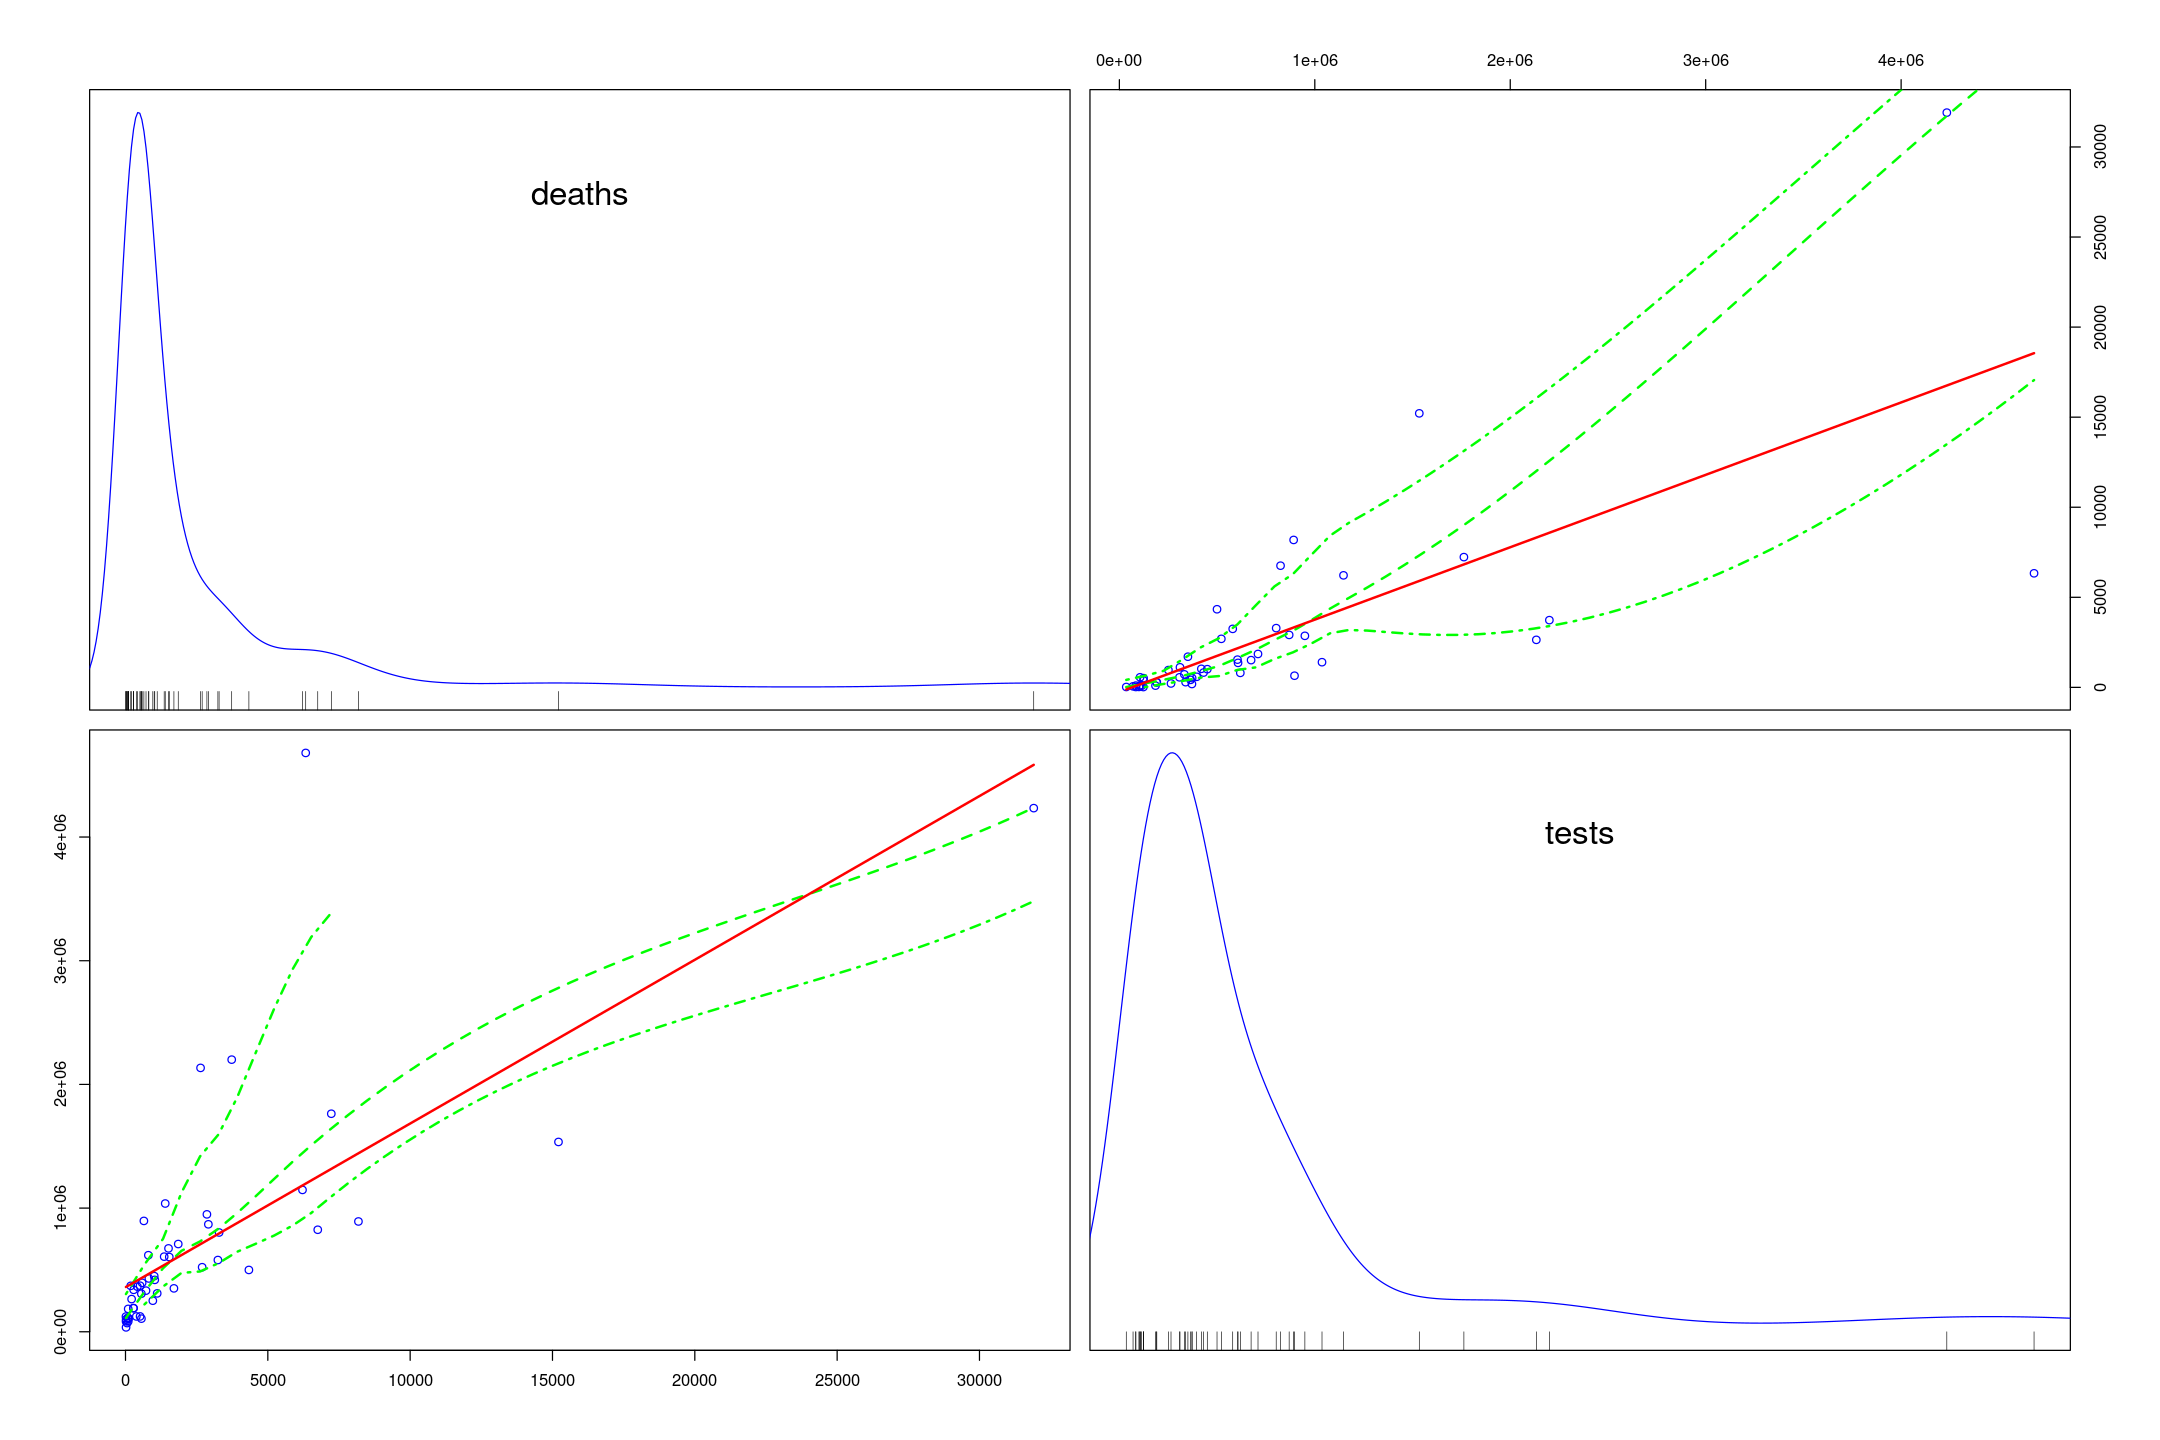

In [9]:
# Model 1 : scatterplot to represent the relationship between 
# Total Death and Total Test Results
# https://rdrr.io/cran/car/man/scatterplotMatrix.html
options(repr.plot.width=18, repr.plot.height=12)
scatterplotMatrix(df[,c("deaths", "tests")]
                 , regLine = list(col='red'),
                  smooth = list(col.smooth = 'green', col.spread='green'))


We can see from above graphs that the variables *deaths* and *tests* are right-skewed. The rug plot marks in both of the distributions indicate that there are only 1-2 values significantly to the right indicating that there may be outliers. Looking at the scatterplots, we see that, overall, there is a strong positive relationship between deaths and tests as the red smoothing line is positively trending. While the majority of points are clustered around the bottom left, we see some sparse points scattered around supporting the idea that there may be outliers. 

In [10]:
####### Summary diagnostics for death and test(model 1) ############
paste("The summary of death variable is")
summary(death)
paste("The summary of test variable is")
summary(test)

[1] "The summary of death variable is"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   16.0   280.5   820.0  2536.7  2776.5 31906.0 

[1] "The summary of test variable is"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35327  187374  395647  695646  813577 4680138 

The summary results of *death* and *test* variables indicate that the data does not have any erroneous data or blank values and the data is clean. We also see that the mean is significantly greater than the median for both variables indicating right skew. The range for both variables also varies greatly, moreso for deaths from 16 to 31,906 indicating that states have very different death numbers.


Call:
lm(formula = death ~ test)

Coefficients:
(Intercept)         test  
 -2.593e+02    4.019e-03  


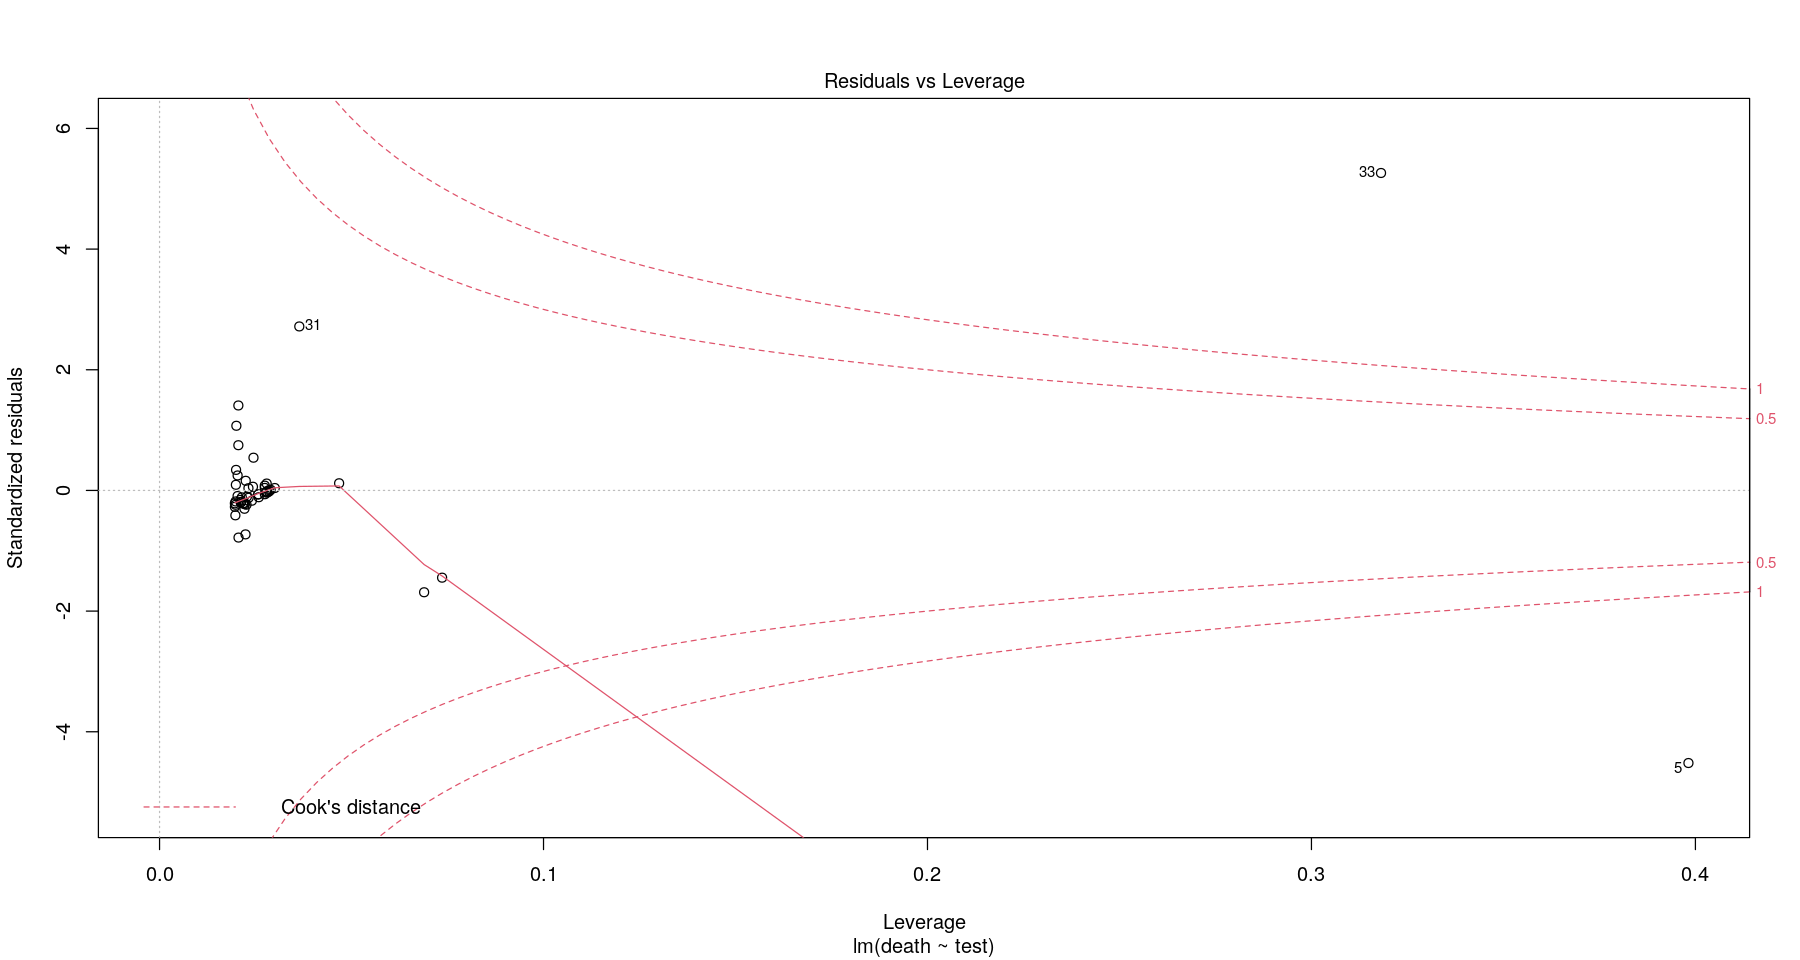

In [11]:
####### Outlier Analyis (model 1) ###############################
options(repr.plot.width=15, repr.plot.height=8)
(m11= lm(death ~ test))
plot(m11, which = 5)

From the above outlier analysis it was found that almost all the values have Cook's distance less than 1 except for two values (points 33 and 5) which represent New York and California, respectively. Looking at the Covid-19 trends, New York and California have had more tests and deaths compared to other states due to their urban populations and higher population densities. These results are not inaccurate and altering these outliers would significantly affect the regression results. However, we will keep the outliers, as they are not errorneous, and New York and California indeed had some abnormal results compared to other states in the pandemic and removing them could mean losing statistically information.

From the prior scatterplots, we know both variables are right-skewed indicating that a log-transform could potentially normalize the variables. This transform could also help normalize the outliers.

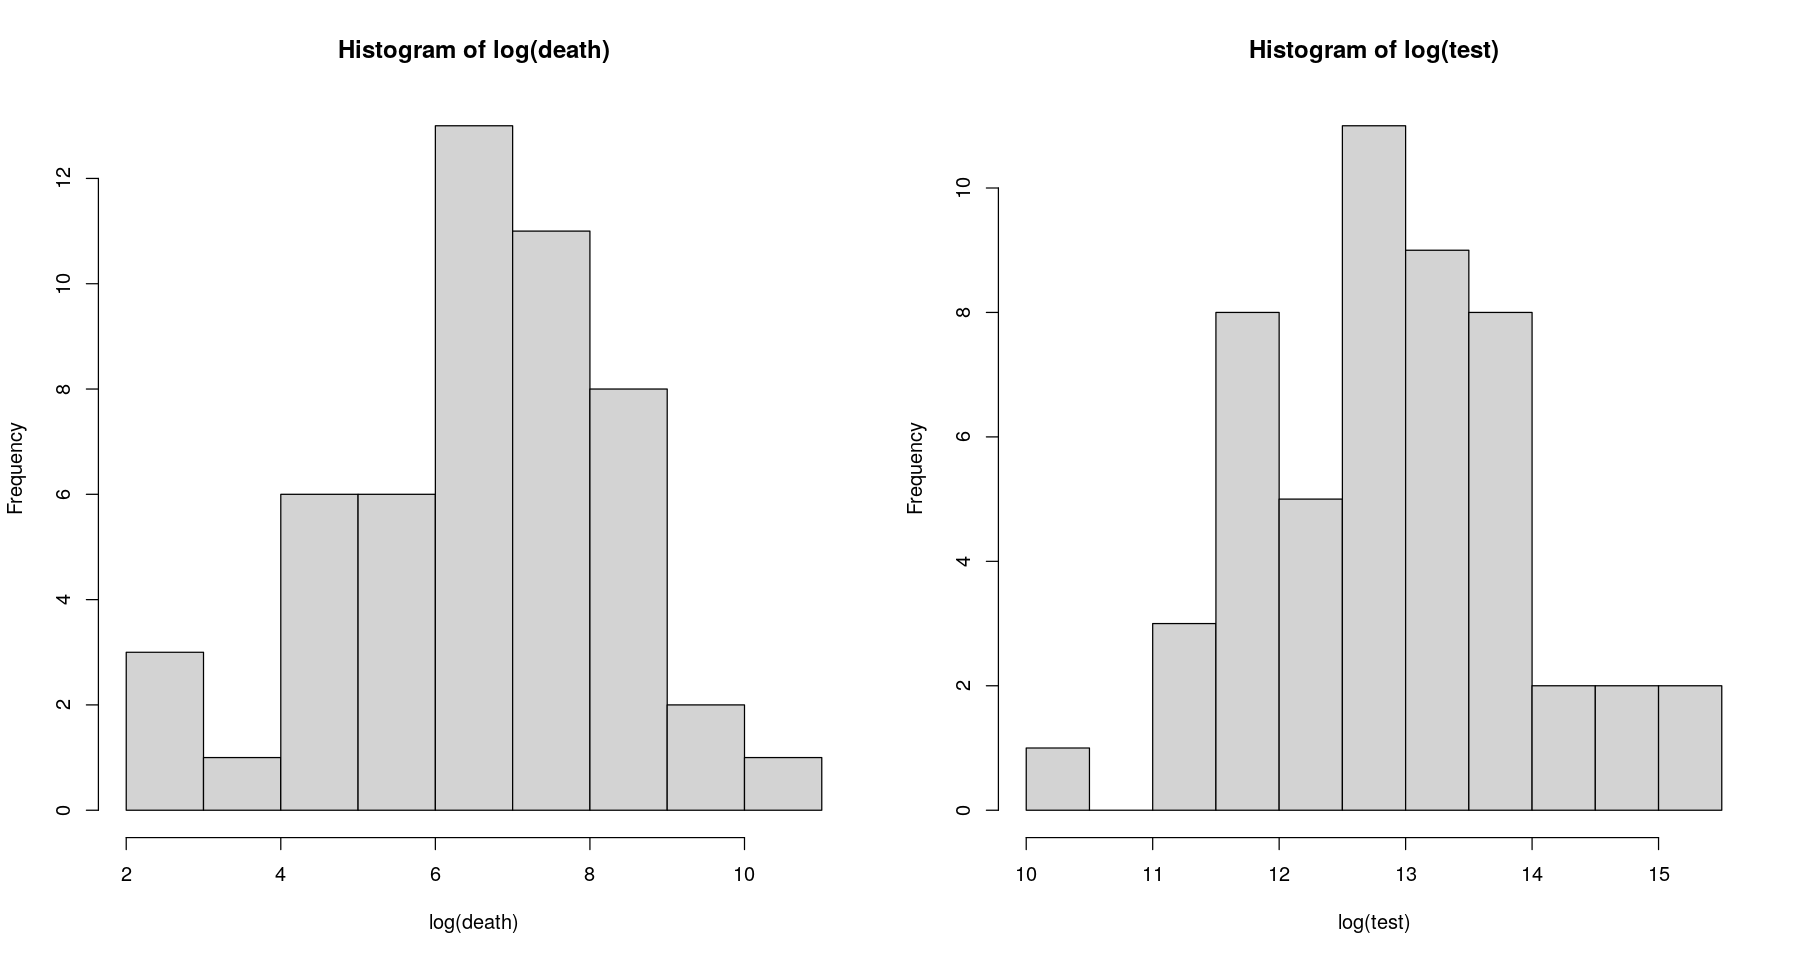

In [12]:
####### Transformations (model 1) #################################
par(mfrow=c(1,2))
options(repr.plot.width=15, repr.plot.height=8)

# Measuring the histograms of log transformed death and test
hist(log(death))
hist(log(test))

After log transforming the *death* and *test* variables, we were able to reduce the right-skew nature of the data making the two variable representations more normal. This transformation also helps reduce the non-normality of the two outliers. From these results, a log-log transform would be a good idea for the model.

In [13]:
##### R-squared and coeffients for (model 1) transformations #########
# R-squared and coefficient for original model
paste("Model for death ~ test:")
(model11 = lm(death ~ test))
cat("R-squared value lm(death ~ test):",summary(model11)$r.squared)

# R-squared and coefficient for log(death) and test
paste("Model for log(death) ~ test:")
(model12 = lm(log(death) ~ test))
cat("R-squared value log(death) ~ test:",summary(model12)$r.squared)

# R-squared and coefficient for log(death) and log(test)
paste("Model for log(death) ~ log(test):")
(model13 = lm(log(death) ~ log(test)))
cat("R-squared value log(death) ~ log(test):",summary(model13)$r.squared)


[1] "Model for death ~ test:"


Call:
lm(formula = death ~ test)

Coefficients:
(Intercept)         test  
 -2.593e+02    4.019e-03  


R-squared value lm(death ~ test): 0.5321404

[1] "Model for log(death) ~ test:"


Call:
lm(formula = log(death) ~ test)

Coefficients:
(Intercept)         test  
  5.735e+00    1.243e-06  


R-squared value log(death) ~ test: 0.4102215

[1] "Model for log(death) ~ log(test):"


Call:
lm(formula = log(death) ~ log(test))

Coefficients:
(Intercept)    log(test)  
    -12.160        1.456  


R-squared value log(death) ~ log(test): 0.771184

As we saw from the exploratory analysis, log transforms can normalize the data, so we experimented with different combinations of variables on the model and calculated the R-squared
value for each transformation. Of all the results we observed, lm(formula = log(death) ~ log(test)) had the highest R-squared value 0.771 making it the strongest proponent for Model 1.

From the specification lm(formula = log(death) ~ log(test)),
we get the coefficient $\beta_1$ as 1.456 which means for every 1% rise in test cases there is a rise in 1.456% of total deaths. The high R-squared value of 0.771 means that we are able to explain about 77% of the variation between deaths and tests showing high effect size between the two variables.

In [14]:
coeftest(model13, vcov = vcovHC, level = 0.05)


t test of coefficients:

             Estimate Std. Error t value  Pr(>|t|)    
(Intercept) -12.15991    1.73262 -7.0182 6.216e-09 ***
log(test)     1.45576    0.13355 10.9009 1.063e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The coeftest results indicate that the variables have a highly statistically significant result with p-values less than 0.001 and we keep *test* as part of the model.



### Model 2

#### Total Deaths ~ Total Test Results + Population Density + Percent at risk for serious illness due to COVID

The second model specification adds key covariates based on the contributing factors that could lead to more deaths. In addition to *test*, we add tthe two following variables:

- ***density*** measures the population density per square miles in a state. Intuitively, we expect this variable to be positively correlated with *deaths* as we expect states with higher population densities to spread COVID more easily resulting in more deaths. A key factor of death is catching the disease and  *density* captures this measure without adding perfect multicollinearity concerns.
- ***risk*** measures the percent at risk for serious illness due to COVID and can be seen as the percentage of people who are at higher risk for death if they contract the virus. We treat this variable as a key covariate, because the higher the at risk percentage, the more deaths we would expect in a state.


Below is the detailed EDA and transformations that were applied for the model specification:


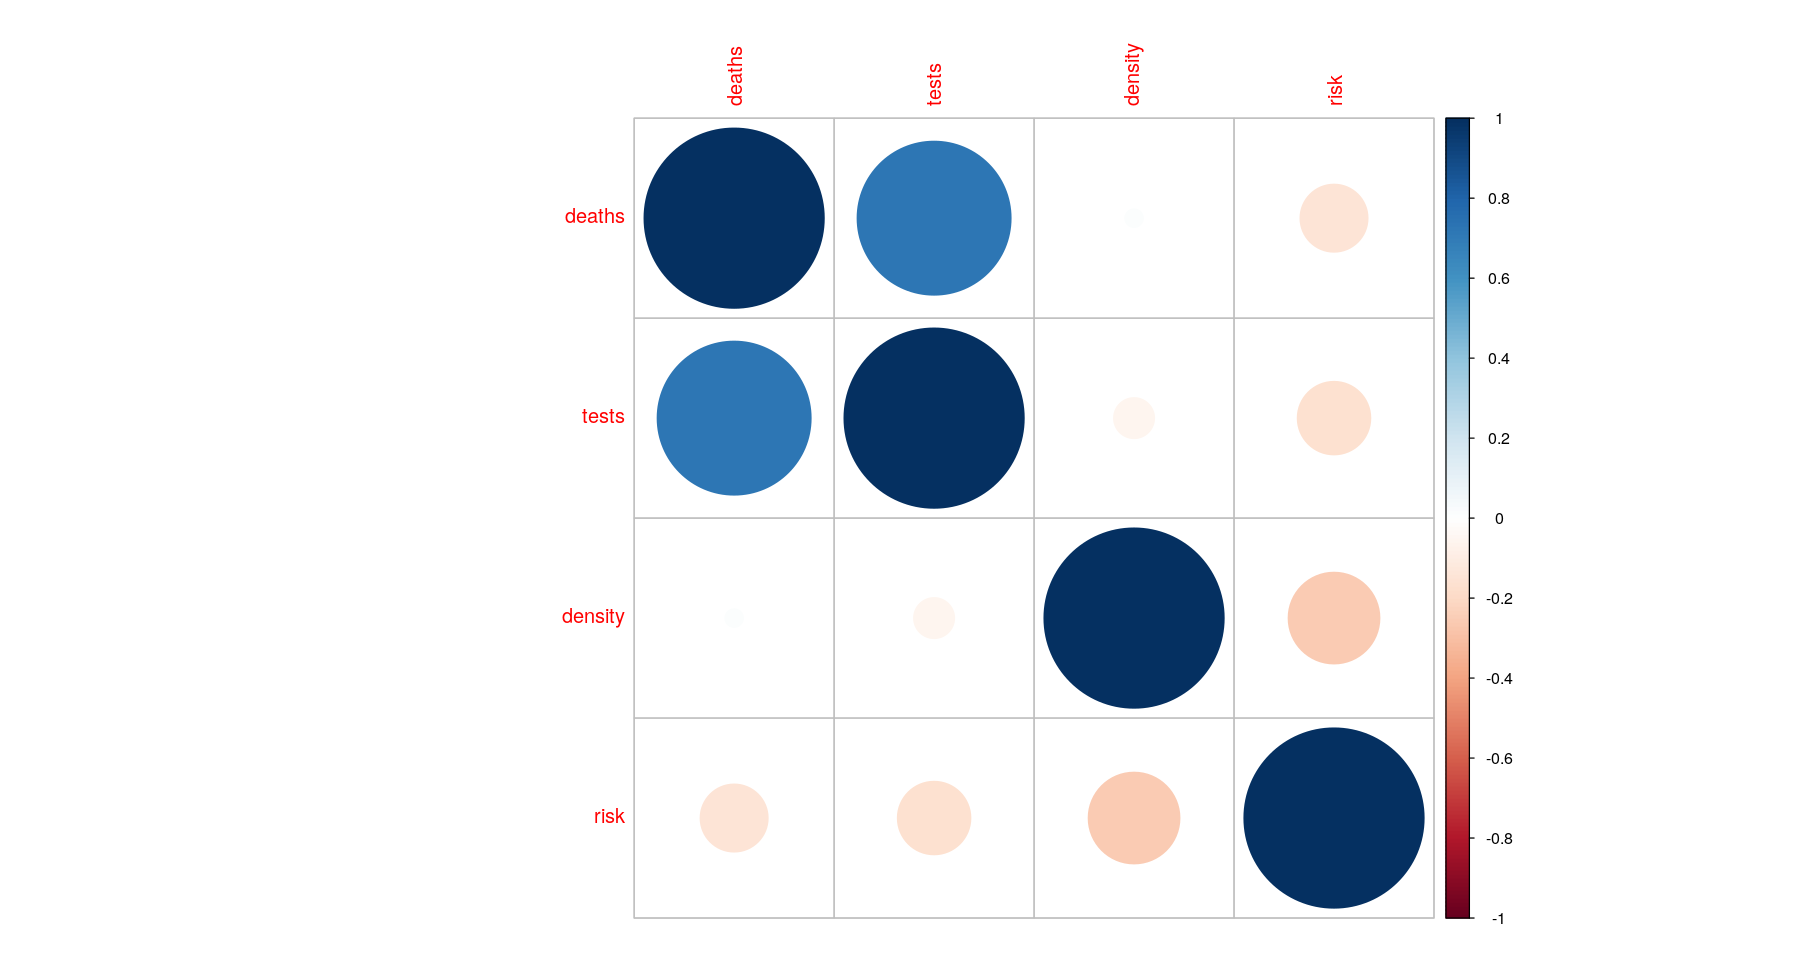

In [15]:
####### Examine Multicollinearity for model 2 ###############
# Using the below correlation plot to measure the correlation
# effect available between other variables available in data
options(repr.plot.width=15, repr.plot.height=8)
corrdat = df[,c("deaths", "tests", "density", "risk")]
corrdat.cor = cor(corrdat, method = c("pearson"))
corrplot(corrdat.cor)

Here are the relationships we identified from the above graph:

*deaths* have strong positive relationship with *tests*
and have a weak relationship with *risk* and no correlation with *density*. Looking at this figure, there is no perfect collinearity between any of the variables. 

The only highly correlated variables are *tests* and *deaths* and this correlation can explain why *tests* was statistically significant in model 1 and why the R-squared value for model 1 was high. Intuitively, this makes sense, but the correlation is not perfectly collinear to the point that we need to remove *tests*.

In [16]:
####### Examine the summary plots for model 2 ######################
paste("Summary plot of density:")
summary(density)
paste("Summary plot of risk:")
summary(risk)

[1] "Summary plot of density:"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.11    48.66    93.24   392.64   209.56 11496.81 

[1] "Summary plot of risk:"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  30.00   35.95   38.30   38.15   40.65   49.30 

The summary results of *density* and *risk* indicate that the the data does not have any erroneous data or blank values and the data is clean. The mean is higher than the median for density indicating right-skew, but the summary of *risk* indicates a less skewed data set as the mean and median differ only by 0.15. The range for *density* is also high ranging from 1.11 to 11496.81 suggesting population density per state varies quite a lot and we can imagine this makes sense knowing states like Alaska versus New Jersey.

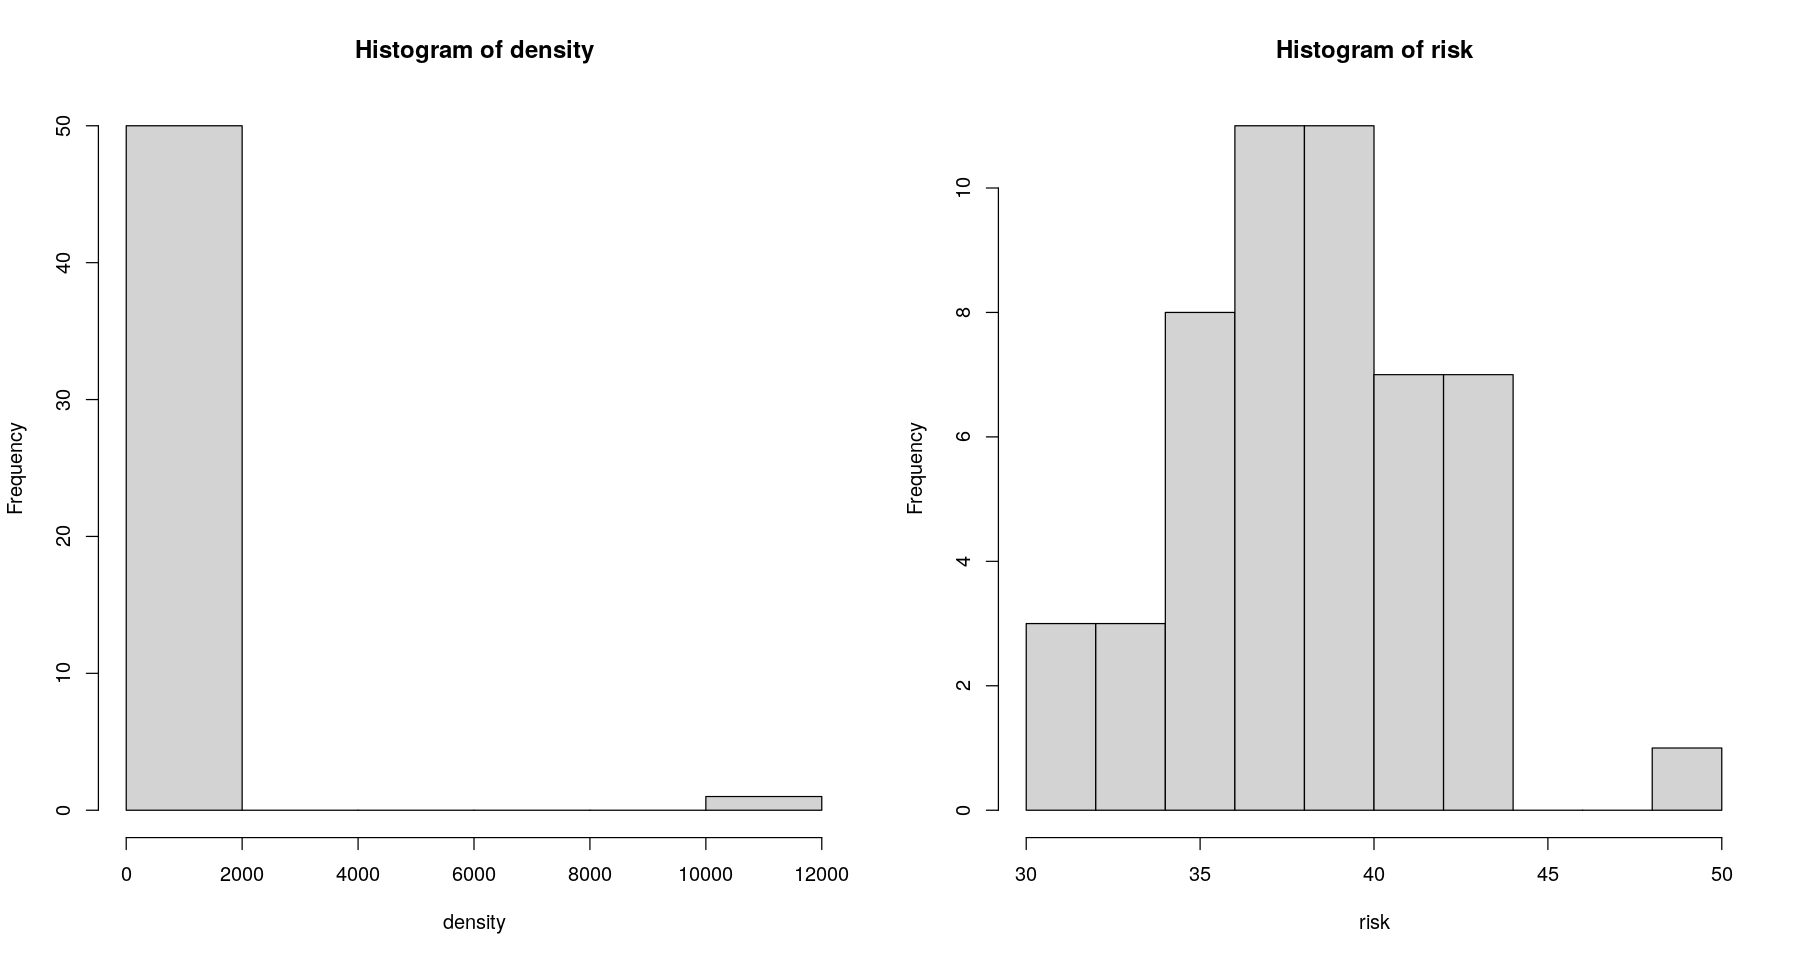

In [17]:
####### Examine the histograms for model 2 #########################
par(mfrow=c(1,2), cex = 1)
options(repr.plot.width=15, repr.plot.height=8)

hist(density)
hist(risk)

From the histogram distribution, *density* has right skew whereas *risk* 
has a seemingly more  normal distribution. These graphs support what we saw from the variable summaries.


Call:
lm(formula = death ~ density)

Coefficients:
(Intercept)      density  
  2.524e+03    3.337e-02  


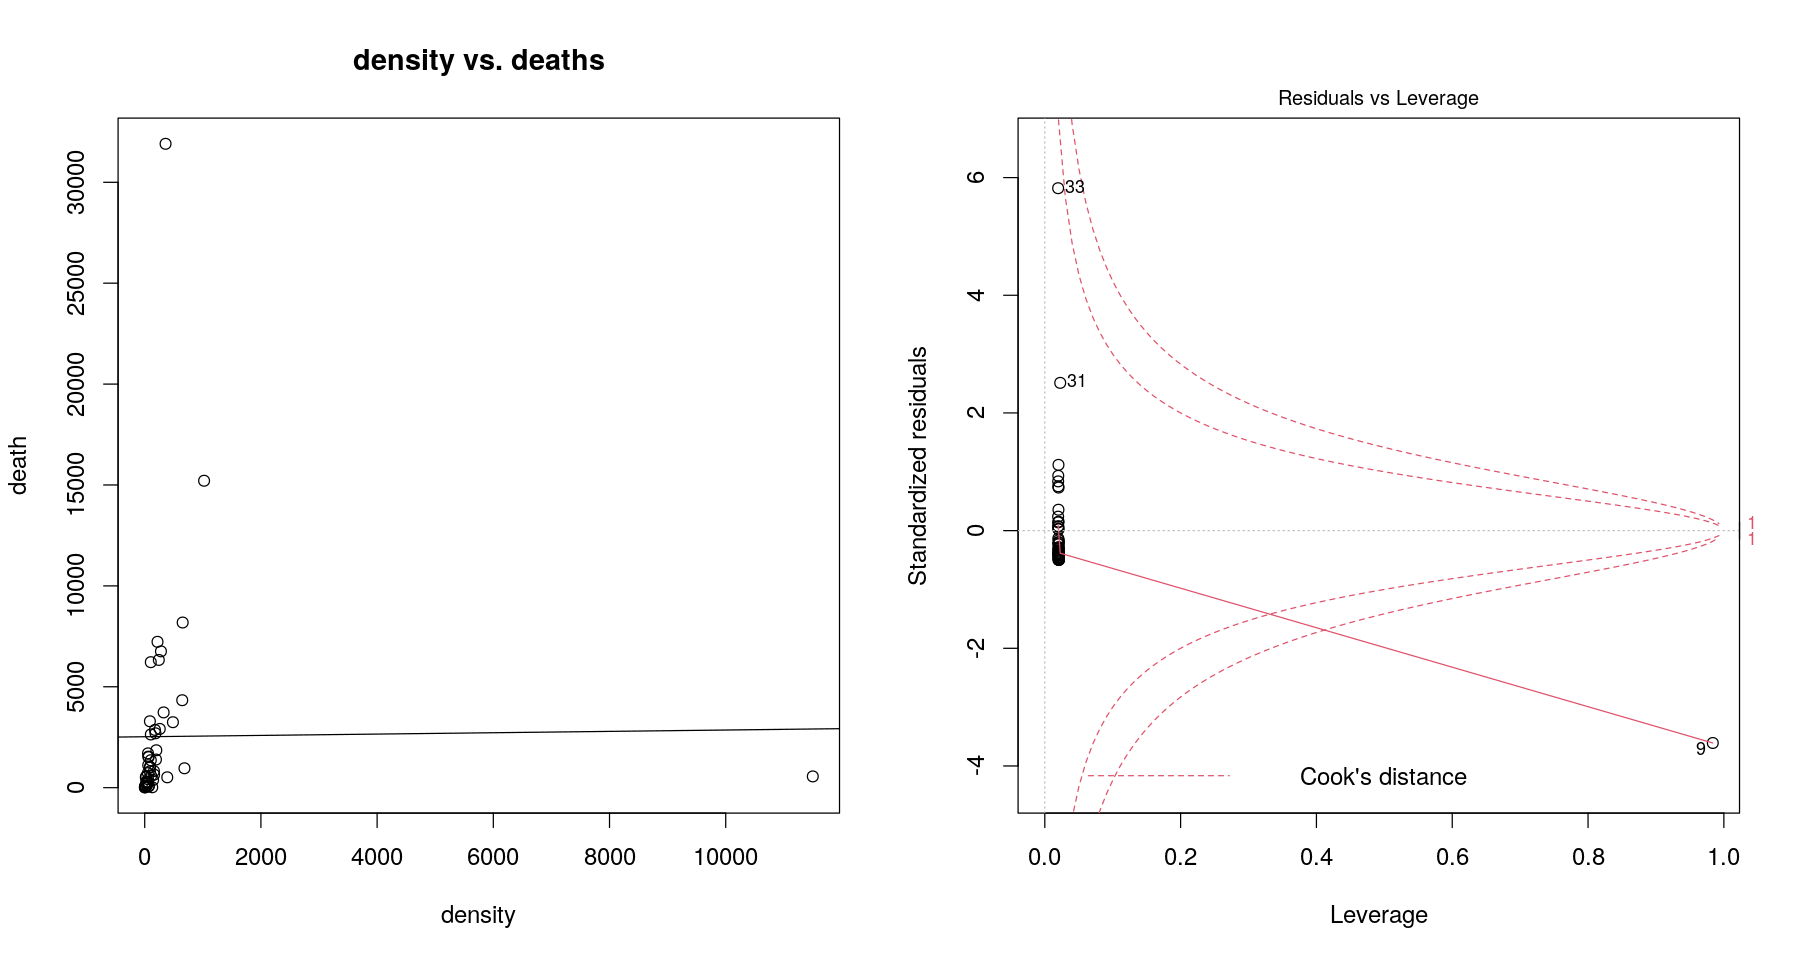

In [18]:
####### Outlier Analyis Model 2(density vs deaths) ################
par(mfrow=c(1,2), cex = 1.2)
options(repr.plot.width=15, repr.plot.height=8)

plot(jitter(density),jitter(death), main = 'density vs. deaths', 
     xlab = 'density', ylab='death')
(m21= lm(death ~ density))
abline(m21)

suppressWarnings(plot(m21, which = 5))

From the scatter plot above for *density* vs. *death*, we see most of the values are spread between (0-1000) for *density* and (0-5000) for *death* with very few abnormal values for *density* (one point >10000) and *death* approx.(two points between 15000 and 30000)).

The residual vs leverage plot, does detect outliers that has a Cook's distance greater than 1 (i.e. an outlier) for District of Columbia (index 9). The point with index 33 (New York) also has a high Cook's distance that is nearly 1 and we can also treat this point as an outlier.

These outliers are influential points that would affect the model greatly, but we have validated that there are no errors related to the data for District of Columbia and New York, hence we decided to keep them in our analysis as we do not want to drop points unless there is an error in the dataset. Intuitively, New York and the District of Columbia are crowded metropolitan areas and it makes sense their population densities would be higher. Knowing that density is right-skewed, a log-transform could help normalize the data and the outliers. 


Call:
lm(formula = death ~ risk)

Coefficients:
(Intercept)         risk  
     9939.1       -194.1  


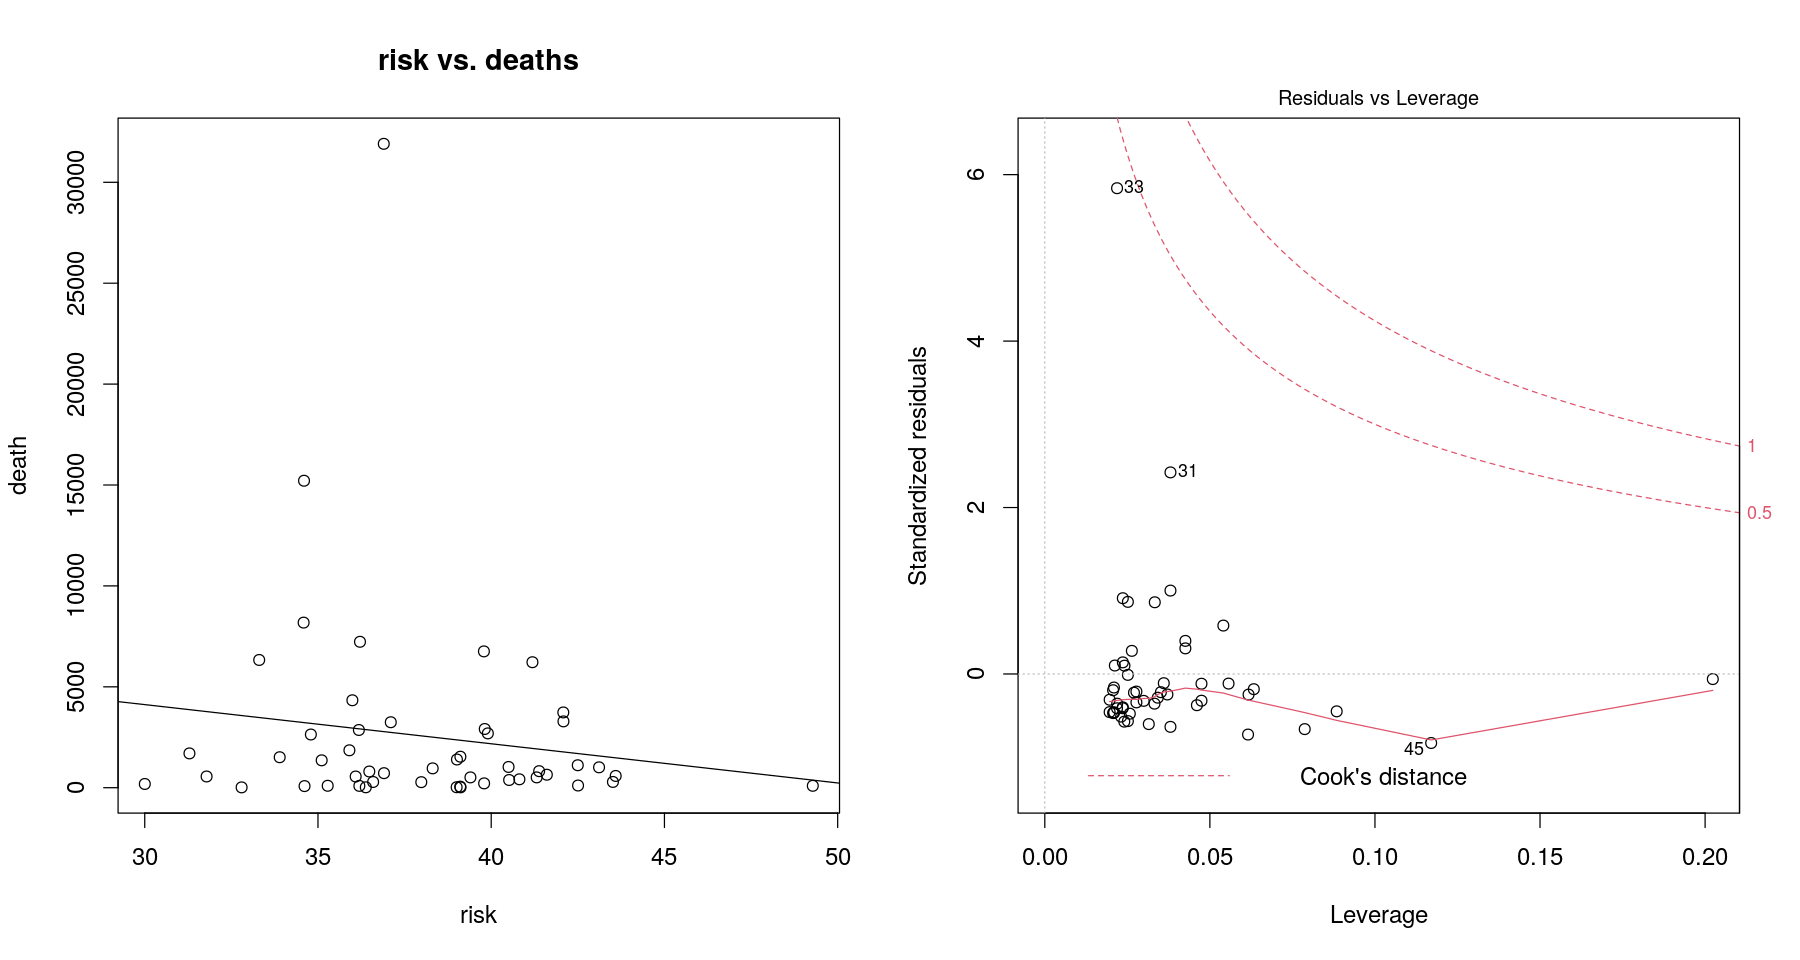

In [19]:
####### Outlier Analyis Model 2(risk vs deaths) ################
par(mfrow=c(1,2), cex = 1.2)
options(repr.plot.width=15, repr.plot.height=8)

plot(jitter(risk),jitter(death), main = 'risk vs. deaths', xlab = 'risk', ylab='death')
(m22= lm(death ~ risk))
abline(m22)

plot(m22, which = 5)

From the scatter plot, we see that the deaths start to rise for states with a certain percentage of risk groups and then fall for states having higher risk percentage following a bell curve. Overall, the deaths seems to have a negative relationship with the at risk percentage from the trendline sloping downwards with an increase in risk. The residual vs leverage plot, does not detect any outlier since all points have a Cook's distance less than 1 hence we can conclude that the outliers don't infuence the regression results even if they are altered. However, New York (point 33) has a Cook's distance close to 0.5 following similar results to the prior residuals vs leverage plot, but as we verified there is nothing wrong with the data and we keep this point as it may contain statistically important information. A log transform on *risk* may be necessary to help normalize the variable.

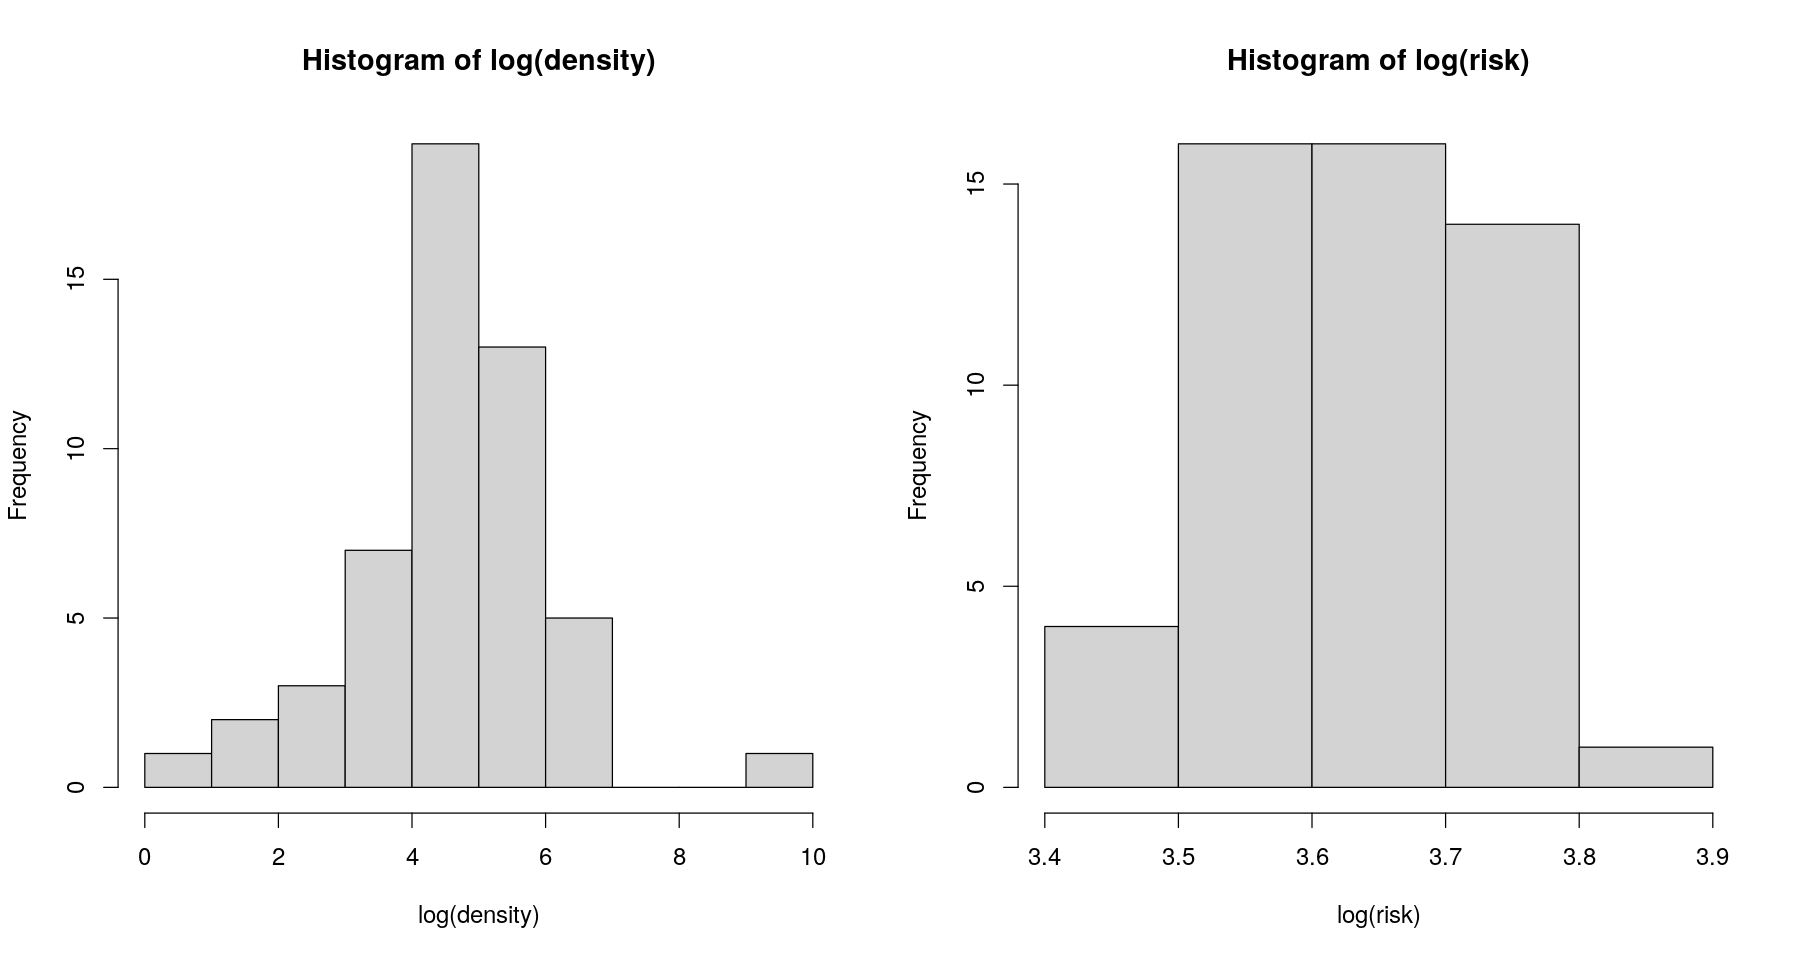

In [20]:
####### Examine the histograms for (model 2) transformations #########
par(mfrow=c(1,2), cex = 1.2)
options(repr.plot.width=15, repr.plot.height=8)
hist(log(density))
hist(log(risk))

After log transforming *density* and *risk*, we were able to reduce the right-skew nature of the data for *density* suggesting that a log-transform is a necessary step before modeling with this variable. However, a log-transform on *risk* did not improve the distribution compared to the raw data  so we do not take a log-transform on this variable.

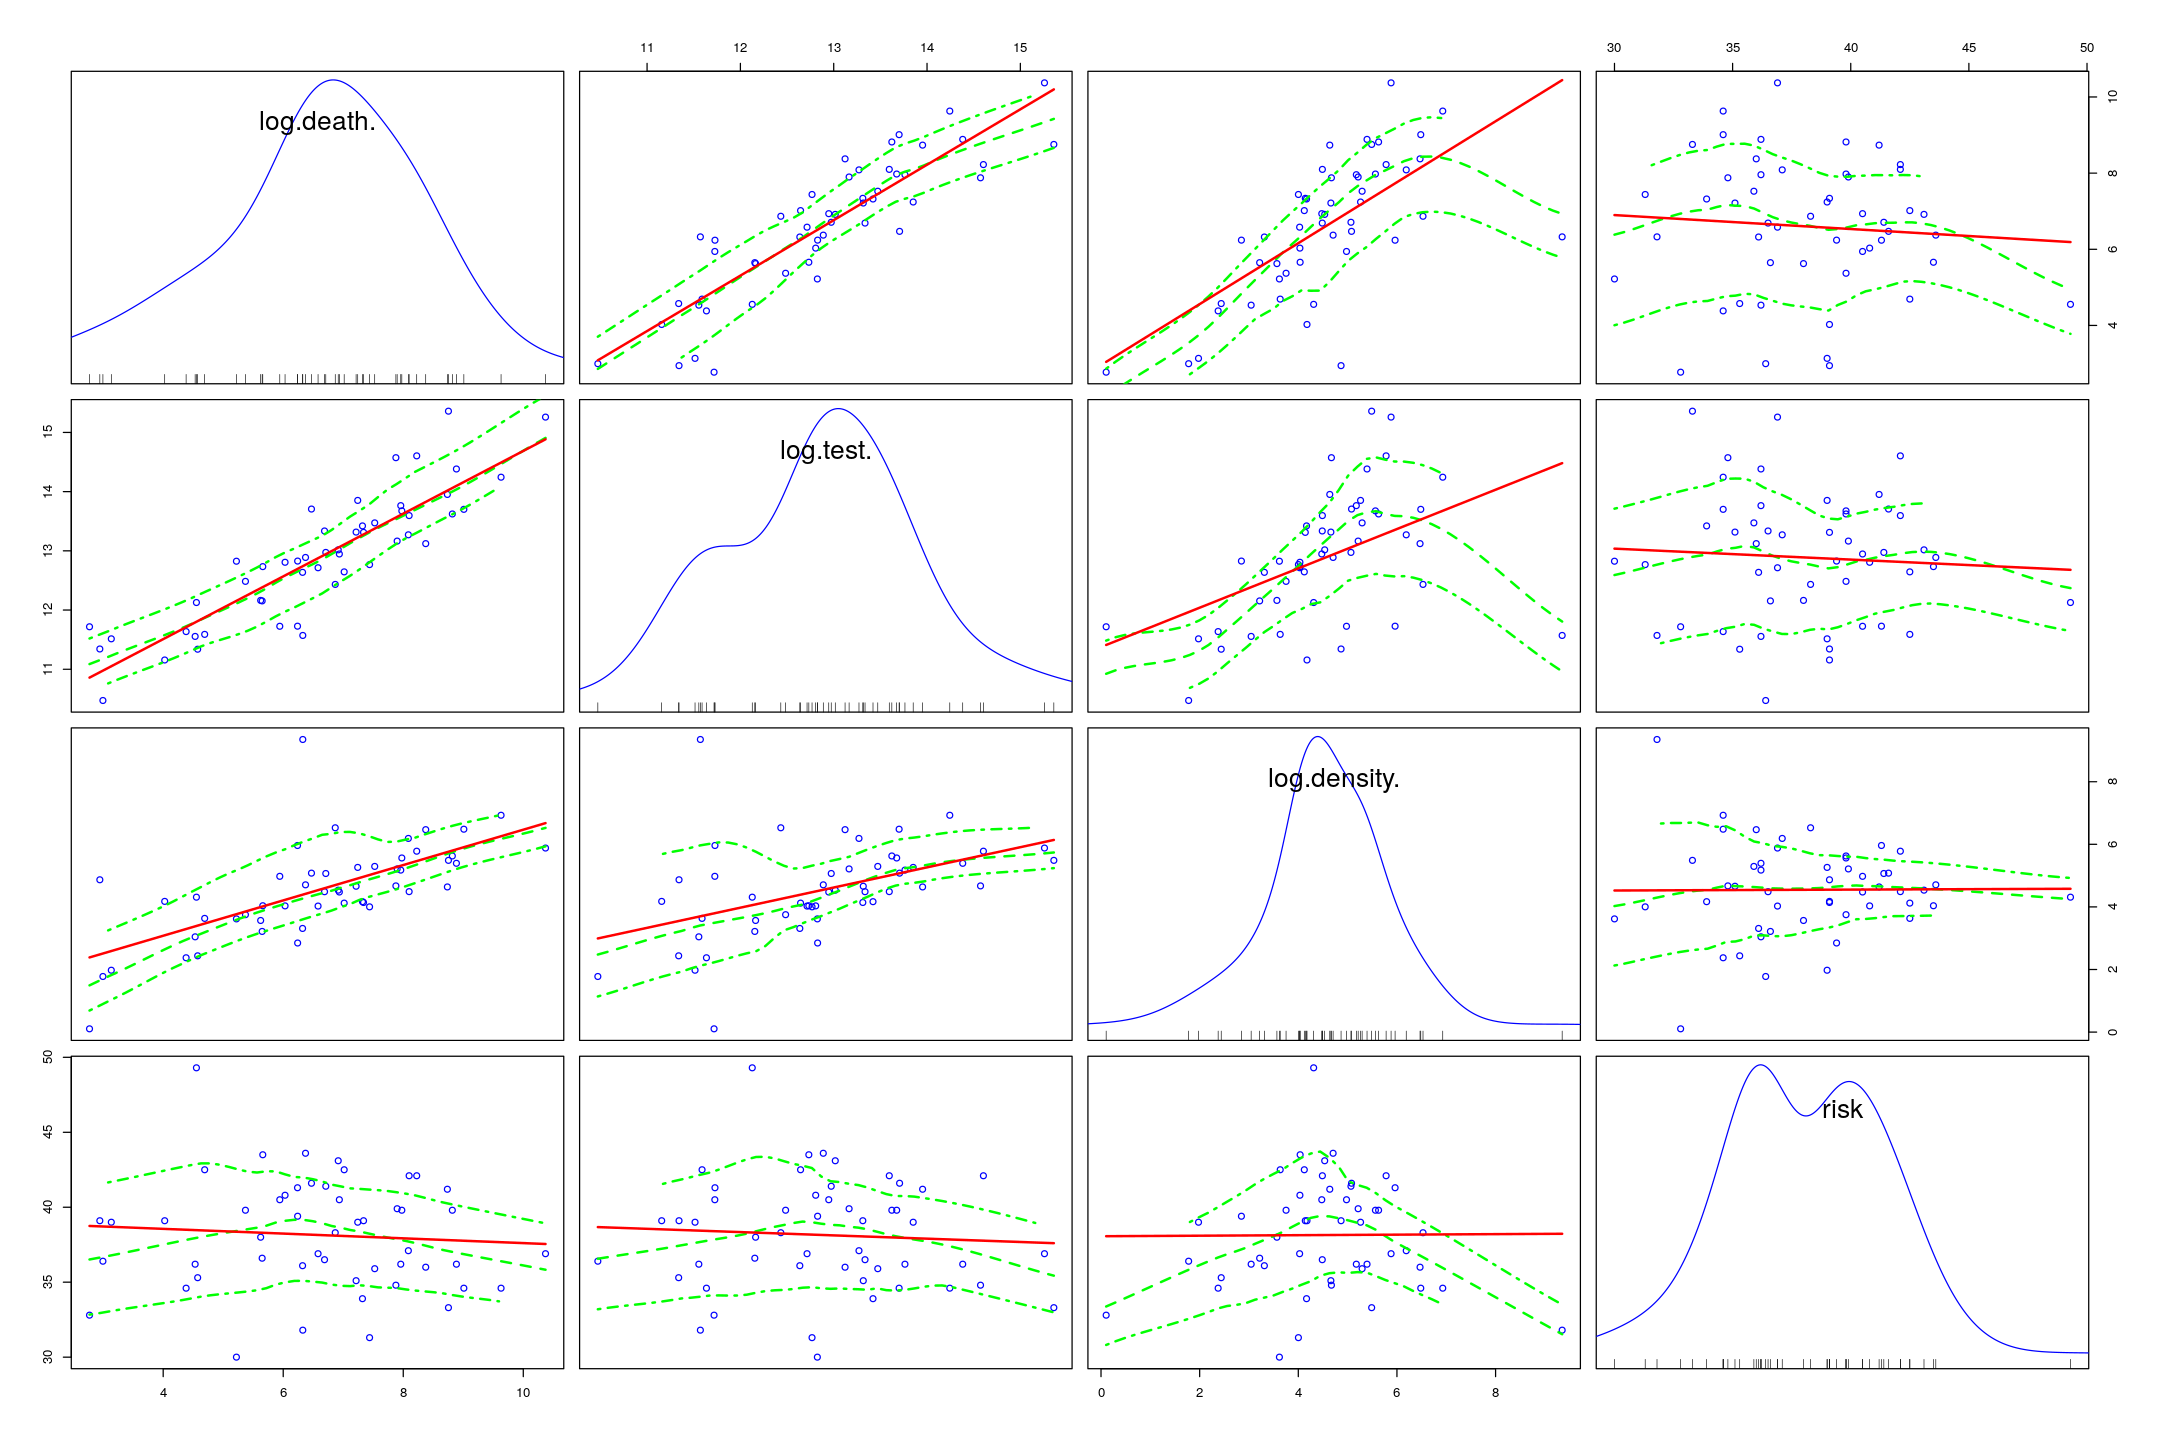

In [21]:
# Model 2 : scatterplot to represent the relationship between 
# ""deaths", "tests", "density", "risk",
options(repr.plot.width=18, repr.plot.height=12)

df$'log(death)' = log(death)
df$'log(test)' = log(test)
df$'log(density)' = log(density) 
scatterplotMatrix(df[,c("log(death)", "log(test)", "log(density)", "risk")]
                 , regLine = list(col='red'),
                  smooth = list(col.smooth = 'green', col.spread='green'), cex.labels = 2)

Applying the necessary transforms to the variables, we can see their relationships with the above scatterplots.

- From the above graph we can see a positive relationship between *log(death)* and *log(tests)* and *log(density)*. 

- For *risk*, there is a weak negative relationship with *log(death)* (but *log(death)* peaks for certain groups than others)

- *log(death)* and *log(density)* have no relationship from the above graphs as seen by the horizontal, red line

- The highest correlations are still between *log(death)* and *log(test)* as seen with the correlation plot. 

Based on these results, are variables are ready to be used for modeling.

In [22]:
##### R-squared and coeffients for model 2 transformations #########
# R-squared and coefficient for original model2
paste("Model for lm(death ~ test + density + risk):")
(model21 = lm(death ~ test + density + risk))
cat("R-squared value:",summary(model21)$r.squared)

# R-squared and coefficient for log transformed model2
# No log-transform on risk
paste("Model for lm(log(death) ~ log(test) + log(density) + risk:")
(model22 = lm(log(death) ~ log(test) + log(density) + risk))
cat("R-squared value:",summary(model22)$r.squared)

[1] "Model for lm(death ~ test + density + risk):"


Call:
lm(formula = death ~ test + density + risk)

Coefficients:
(Intercept)         test      density         risk  
 147.837063     0.004024     0.144652   -12.251315  


R-squared value: 0.5345342

[1] "Model for lm(log(death) ~ log(test) + log(density) + risk:"


Call:
lm(formula = log(death) ~ log(test) + log(density) + risk)

Coefficients:
 (Intercept)     log(test)  log(density)          risk  
    -9.99324       1.19151       0.40483      -0.01579  


R-squared value: 0.8623694

In [23]:
coeftest(model22, vcov = vcovHC, level = 0.05)


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept)  -9.993242   2.380373 -4.1982 0.0001187 ***
log(test)     1.191514   0.160843  7.4079 1.973e-09 ***
log(density)  0.404831   0.116939  3.4619 0.0011529 ** 
risk         -0.015794   0.036609 -0.4314 0.6681295    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The coeftest results indicate that the *log(test)* and *log(density)* are highly statistically significant and *risk* is not. *log(density)* is not as statistically significant as *log(test)*, but it's p-value is still less than 0.01 indicating it still is statistically significant. Intuitively, we would expect *risk* to be significant, but according to these results, we drop risk for our final second model specification and only keep *log(test)* and *log(density)*.

In [24]:
(model23 = lm(log(death) ~ log(test) + log(density) ))
cat("R-squared value:",summary(model23)$r.squared)


Call:
lm(formula = log(death) ~ log(test) + log(density))

Coefficients:
 (Intercept)     log(test)  log(density)  
     -10.647         1.196         0.403  


R-squared value: 0.8612996

Of all the results we observed, lm(formula = log(death) ~ log(test) + log(density)) had the highest R-squared value 0.861 making it the strongest proponent for the Model 2.The high R-squared value means that we are able to explain 86% of the variation between death rate and the variables showing high effect size between these variables.

From this specification, we get the coefficient $\beta_1$ as 1.196 which means for every 1% rise in test cases there is a rise in 1.196% of total deaths. 
For coefficient $\beta_2$, we get 0.403 which means for 1% rise in population density there is a 0.403% increase in total deaths, which is close to 0 with respect to deaths according to this data and a smaller effect compared to a percent increase in tests. However, a 0.403% increase in the number of deaths can be seen as a practically significant result when applied to population sizes as even a small increase in the number of deaths is cause for concern. 

### Model 3

From model 1, we identified *tests* as a key variable
In addition, from model 2, we identified *density* as the most important covariates that would help us advance our modeling goals as *risk* was not statistically significant.

Here in model 3, we have considered the below variables as covariates erring on the side of inclusion: 

#### TotalDeath ~ Total Test Results + Population Density +  Rate per 100,000 + Cases in last 7 day + Percent living under the federal poverty line (2018) + Days required business close + Children 0-18 + Adults 19-25 + Adults 26-34 + Adults 35-54 + Adults 55-64 + Weekly unemployment insurance maximum amount (dollars) 

Note: Variables related to age demographics(child+young_ad+mil_ad+mid_ad+elderly) are top-coded in nature. To avoid multi-collinearity we exclude the variable for adults in 65+ years of age) and since these are proportion variables, knowing all but one of the groups provides enough information for the last one. 

New variables included are:
- ***rate*** measures the infection rate per 100,000 people. This variable is important to include as it provides a look at spread and we expect this variable to be positively correlated with deaths as the more the disease spreads, the more the number of deaths. 
- ***cases*** measures the number of positive cases in the last 7 days. We include this variable as it provides information about severity of spread and we expect this variable to be positively correlated with *deaths* as the more cases there are, the more likely chance of an increase in deaths. 
- ***poverty*** measures the percent living under the federal poverty line (2018). Based on reports, those with a lower economic status are more prone to catching the disease and suffering from it due to more restricted health care as well as the nature of the jobs those people have. We include this variable to capture the factor of socioeconomic status and expect this to be positively correlated with the number of deaths.
- ***days_business*** measures the days required for non-essential businesses to close up to July 2, 2020. We include this variable because the longer businesses like retail remain closed, the less chance for people to get exposed to the disease. This variable helps capture social policy and we expect this variable to be positively correlated with the number of deaths.
- The ***age demographic variables*** (*child*, *young_ad*, *mil_ad*, *mid_ad*, and *old_ad*) measure the proportion of the states population that fit into the age demographic categories. COVID targets the elderly more often and more seriously than the younger populations so these variables provide important information about which states may be more susceptible to an increase in the number of deaths. We include them as a further breakdown into at risk groups and expect states with higher younger populations to show fewer number of deaths and states with larger older populations to show more deaths.
- ***unemp*** measures the weekly unemployment insurance maximum amount in dollars. We include this variable as it acts as a measure of economic survivability and we believe that higher amounts of unemployment would mean fewer number of deaths as people can more likely be able to afford healthcare or maintain a healthier lifestyle. 

*cases* may seem directly related to the number of deaths, but we still include this variable since it is not necessarily true that catching the disease means someone will die from it. 


In [25]:
##### Deriving R-squared and coeffients for model 3  #########
(model31 = lm(death ~ test + density + rate + cases + pov +
              bus +  child + young_ad + mil_ad + mid_ad + old_ad+
              + unemp))

cat("R-squared value for model3:",summary(model31)$r.squared)


Call:
lm(formula = death ~ test + density + rate + cases + pov + bus + 
    child + young_ad + mil_ad + mid_ad + old_ad + +unemp)

Coefficients:
(Intercept)         test      density         rate        cases          pov  
 -9.548e+02    3.844e-03    3.902e-01    4.240e+00   -1.411e-01    3.231e+00  
        bus        child     young_ad       mil_ad       mid_ad       old_ad  
  8.847e+00    2.955e+04   -4.116e+04   -5.669e+04   -2.448e+04    3.368e+04  
      unemp  
  6.558e+00  


R-squared value for model3: 0.94483

In [26]:
##### Deriving R-squared and coeffients for model 3 
#####We apply a log transform to death, test, and density ######
######### based on the second model specification #########
(model32 = lm(log(death) ~ log(test) + log(density) + log(rate) + log(cases) + pov +
              bus +  child + young_ad + mil_ad + mid_ad + old_ad+
              + log(unemp)))
cat("R-squared value for transformed model3:"
    ,summary(model32)$r.squared)


Call:
lm(formula = log(death) ~ log(test) + log(density) + log(rate) + 
    log(cases) + pov + bus + child + young_ad + mil_ad + mid_ad + 
    old_ad + +log(unemp))

Coefficients:
 (Intercept)     log(test)  log(density)     log(rate)    log(cases)  
  -25.309652      0.709990      0.251447      0.848060      0.213930  
         pov           bus         child      young_ad        mil_ad  
   -0.006295      0.022931     15.639565      2.268874     13.615724  
      mid_ad        old_ad    log(unemp)  
   -6.977436     51.407762      0.479731  


R-squared value for transformed model3: 0.9597229

In [27]:
coeftest(model31, vcov = vcovHC, level = 0.05)


t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)  
(Intercept) -9.5485e+02  2.9926e+04 -0.0319  0.97478  
test         3.8436e-03  1.8864e-03  2.0375  0.05151 .
density      3.9021e-01  2.3092e+00  0.1690  0.86707  
rate         4.2401e+00  1.7884e+00  2.3709  0.02514 *
cases       -1.4111e-01  1.1040e-01 -1.2782  0.21204  
pov          3.2306e+00  1.2477e+02  0.0259  0.97953  
bus          8.8474e+00  5.4811e+01  0.1614  0.87297  
child        2.9554e+04  4.3966e+04  0.6722  0.50717  
young_ad    -4.1161e+04  6.7888e+04 -0.6063  0.54937  
mil_ad      -5.6693e+04  5.2941e+04 -1.0709  0.29370  
mid_ad      -2.4480e+04  5.5074e+04 -0.4445  0.66022  
old_ad       3.3678e+04  8.6444e+04  0.3896  0.69989  
unemp        6.5578e+00  3.4941e+00  1.8768  0.07139 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
coeftest(model32, vcov = vcovHC, level = 0.05)


t test of coefficients:

                Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  -25.3096520   5.5309674 -4.5760 9.517e-05 ***
log(test)      0.7099905   0.1911417  3.7145 0.0009372 ***
log(density)   0.2514467   0.0948152  2.6520 0.0132319 *  
log(rate)      0.8480602   0.1836137  4.6187 8.485e-05 ***
log(cases)     0.2139305   0.1272190  1.6816 0.1041810    
pov           -0.0062951   0.0380876 -0.1653 0.8699547    
bus            0.0229312   0.0084533  2.7127 0.0114731 *  
child         15.6395648   8.4721338  1.8460 0.0758838 .  
young_ad       2.2688738  18.0891350  0.1254 0.9011144    
mil_ad        13.6157235   9.9145812  1.3733 0.1809558    
mid_ad        -6.9774355  10.5927574 -0.6587 0.5156677    
old_ad        51.4077620  15.9384711  3.2254 0.0032836 ** 
log(unemp)     0.4797306   0.2932906  1.6357 0.1135120    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The base model had the lower R-squared value (0.945) and the coeftest results indicate that only *rate* is statistically significant out of all the variables. However, the p-value is only less than 0.05 and its estimate is nearly double its standard error indicating that, practically speaking, even *rate* may not be truly statistically significant. It's interesting to see such a high R-squared value, but potentially none of the predictor variables are statistically significant.

The log model had a higher R-squared value (0.960) and the coeftest results indicate that *test*, *density*, *rate*, *bus*, and *old_ad* are statistically significant. *test* and *rate* have p-values less than 0.001, but for *density* and *bus*, the coefficient is almost the same as double the standard error suggesting the variables may not truly be statistically significant and *child* has a coefficient values less than double the standard error indicating it is not statistically significant. We choose to only log transform *death*, *test*, *density*, *rate*, *cases*, and *unemp* based on the results from the first and second model specifications as well as for interpretability reasons. It would not make sense to log transform variables like the age demographic ones as they are already percentages and log transforms are interpreted as percent changes.

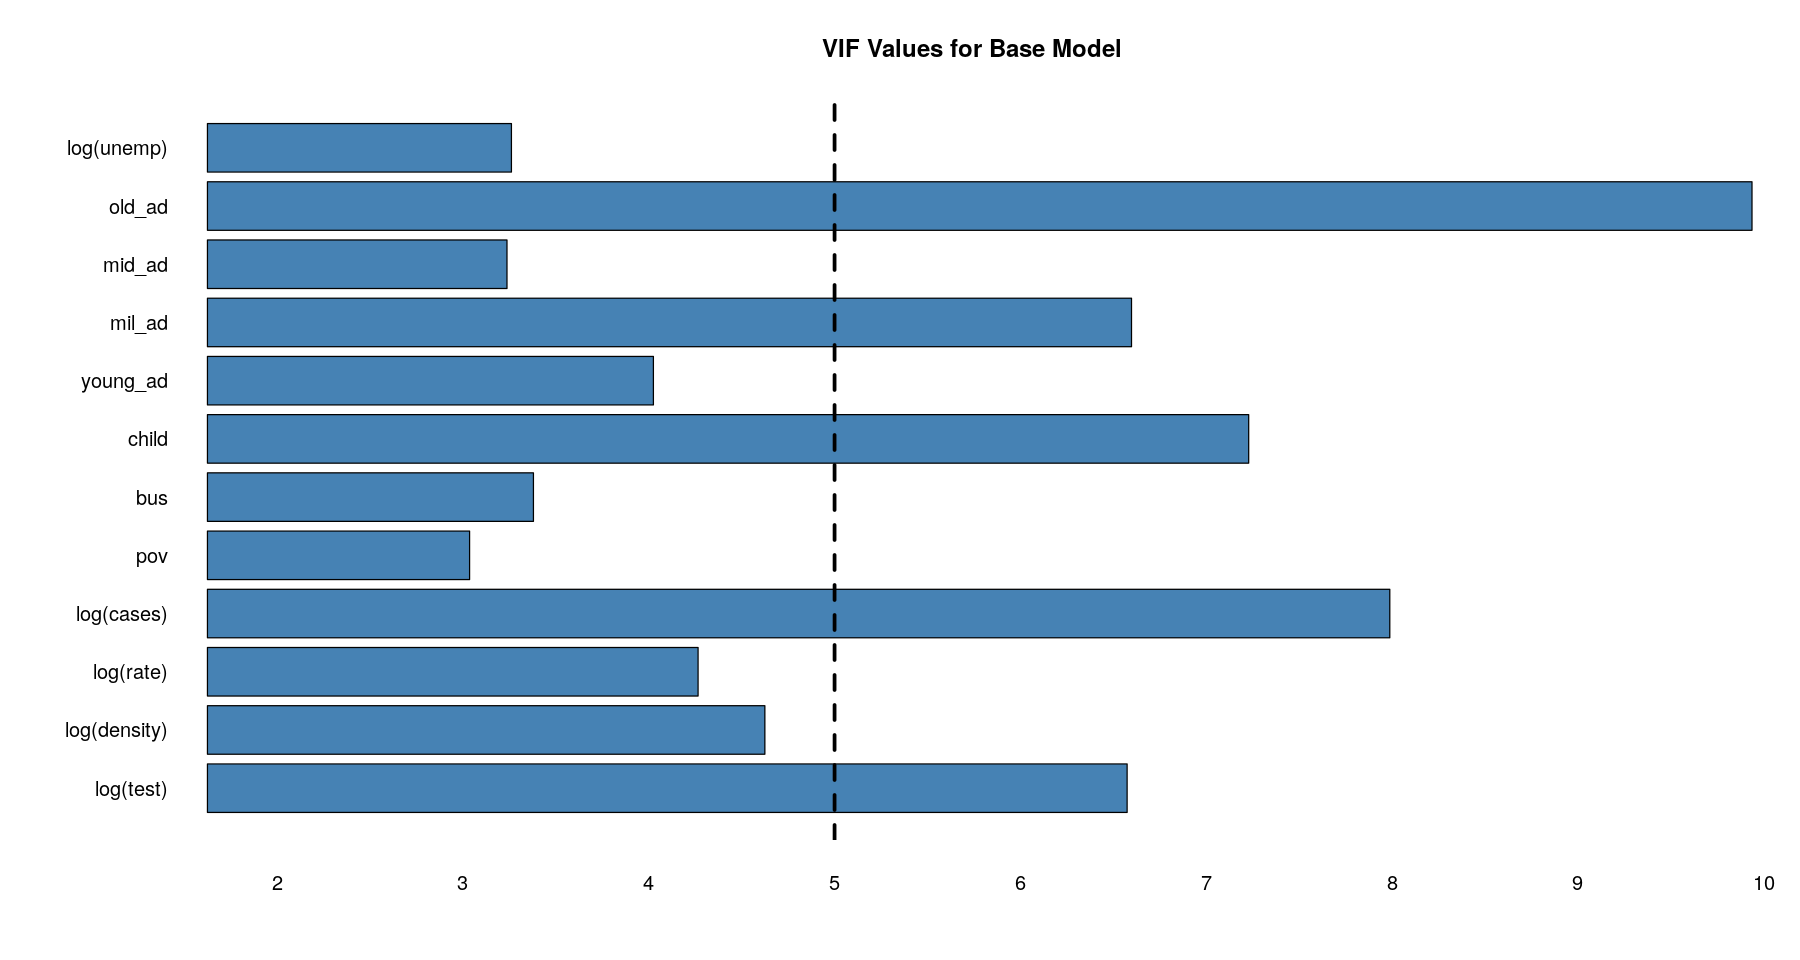

In [29]:
#create vector of VIF values
vif_values <- vif(model32)
options(repr.plot.width=15, repr.plot.height=8)
par(mar=c(5,8,4,2)) 
#create horizontal bar chart to display each VIF value
x = barplot(vif_values, main = "VIF Values for Base Model", 
        horiz = TRUE, col = "steelblue", las = 2, xaxt='n')
labs = paste(names(table(seq(2,12, by = 1))))
text(cex=1, x=x-.25, y=-1.25, labs, xpd=TRUE, srt=0)

#add vertical line at 5
abline(v = 4.05, lwd = 3, lty = 2) 

We use two different model transforms for the third model specification. The first one is a base model with no transformations applied and the second applies the log-transformations to only *death*, *test*, *density*, *rate*, *cases*, and *unemp* according to the results from the second model specification. 

The R-square results for the first model had an R-squared value of 0.946. This high R-squared value would mean that we are able to explain 95% of the variation between deaths and all the predictor variables using this model, showing a high effect size between these variables. The R-squared for the transformed model with log-transformations is 0.960 indicating this model explains about 96% of the variation. This R-squared is higher than the base model. Since we are erring on the side of variable inclusion for this model specification, we need to examine the variance inflation factor graph above. Variance inflation factor measures how much the variance of a regression coefficient is inflated due to multicollinearity. We see that *test*, *cases*, *child*, *mil_ad*, and *old_ad* all have values greater than 5 indicating there is significant multicollinearity in the data. Intuitively,  it makes sense that the age demographics are correlated, but we did not expect the multicollinearity to be this extreme. However, since this specification erred on the side of inclusion, this is not unexpected. 

Interpretation for base model with higher r-squared:
- ***test*** - Increasing the number of tests by 1% leads to a 0.710% increase in the number of deaths.
- ***density*** - a one percent increase in the population density leads to a 0.251% increase in the number of deaths.
- ***rate*** - a one percent increase in the rate per 100,000 leads to a 0.848% increase in the number of deaths.
- ***cases*** - a one percent increase in the number of cases in the last 7 days leads to a 0.214% increase in the number of deaths.
- ***pov*** - a one percent increase in the rate living under the federal poverty line leads to a 0.006 unit decrease in the number of deaths.
- ***bus*** - a one day increase in the days essential business were closed leads to a 0.023 increase in the number of deaths.
- ***child*** - a one percent increase in the age group from 0-18 leads to a 15.640 increase in the number of deaths.
- ***young_ad*** - a one percent increase in the age group from 19-25 leads to a 2.269 increase in the number of deaths.
- ***mil_ad*** - a one percent increase in the age group from 26-34 leads to a 13.616 increase in the number of deaths.
- ***mid_ad*** - a one percent increase in the age group from 35-54 leads to a 6.977 decrease in the number of deaths.
- ***old_ad*** - a one percent increase in the age group from 55-64 leads to a 51.408 increase in the number of deaths.
- ***unemp*** - a one percent increase in the weekly unemployment insurance maximum amount leads to a 0.480% increase in the number of deaths.

The surprising coefficients are *pov*, *bus*, *child*, *young_ad*, *mil_ad*, *mid_ad*, and *unemp*  in which we expected the sign to be the opposite of what the model outputted. However, for the rest of the variables, the results matched our initial hypotheses.

## 3. An Assessment of the CLM Assumptions

We use the model 2 specification since we achieve good results based on the R-squared value and have an intuitive understanding of the model as well. Model 3 already violated the multicollinearity assumption as well.

In [30]:
model23 = lm(log(death) ~ log(test) + log(density))

### Linear in Parameters
Model 2 can be written as

Total Deaths regressed on Total Test Results + Popuplation Density

and translated to the following form:

$y = \beta_0 + \beta_1x_1 +\beta_2x_2+ u$

where $\beta_0, \beta_1, \beta_2 $ are the unknown parameters of interest and $u$ is an unobserved random error or disturbance term. In our case, $y$ represents total deaths, $\beta_1$ represents *test* and $\beta_2$ represents *density*.

All the parameters are linear in relationship with no non-linear relationships.

We have not constrained our error in any way so there's nothing to test and the formula is true for some definition of $u$ which we cal also define as 

$u = y - \beta_0 - \beta_1x_1 -\beta_2x_2 $


### Random Sampling

We have a random sample of $n$ observations, ${(x_{i1}, x_{i2},...,x_{ik}, y_i):i=1,2,...,n}$, following the population model in the linear in parameters assumption. This assumption says that all data points are independent random draws from our population distribution. The data comes is organized on a state level and gathered from multiple sources.

1. The total deaths came from CDC (https://www.cdc.gov/covid-data-tracker/#cases) and this is an aggregate measure of known deaths from COVID-19 state wide. 
2. Population density and the percent at risk data was gathered by multiple doctors and workers from different universities mainly Boston University. (tinyurl.com/statepolicy)

Random sampling can be violated if there is clustering when individuals are collected into groups and researchers can only access a limited number of these groups or autocorrelation when the error for one data point is correlated with the error for the next data point. Since data is on the state level, we can assume that clustering is not an issue as we are not looking at only big cities or rural areas, for example. We are looking at aggregate data. We can also treat states as independent from one another. One concern for autocorrelation may be that neighboring states could affect each other's total cases, but even with this assumption, states still operate independently and we can assume random sampling is still met.

In [31]:
#Durbin Watson test tests for autocorrelation
dwtest(model23)


	Durbin-Watson test

data:  model23
DW = 1.759, p-value = 0.1839
alternative hypothesis: true autocorrelation is greater than 0


The null hypothesis for the Durbin-Watson test is that there is no autocorrelation and the test shows a large p-value (>0.05) so we fail to reject the null hypothesis and conclude that we don't need to worry about autocorrelation.

### No Perfect Collinearity

In the sample (and therefore in the population), none of the independent variables is constant, and there are
no exact linear relationships among the independent variables.

Our model contains two variables:
- Total Test Results
- Population Density

From an intuitive point of view, the number of tests may increase with the population density, but they do not determine each other and are not perfect linear combinations of each other so we don't need to drop either of them.

In [32]:
vif(model23)
#value greater than 5 is problematic so okay here

log(test) log(density) 
    1.272158     1.272158

This variance inflation factor measures how much the variance of a regression coefficient is inflated due to multicollinearity. A VIF value greater than 5 indicates a problematic amount and we see the values are both below 2 indicating that multicollinearity is not an issue.

### Zero Conditional Mean

The error $u$ has an expected value of zero given any values of the explanatory variables. In other words, the value of the explanatory variables must contain no information about the mean of the unobserved factors. $E(u_i | x_{i1},x_{i2},...,x_{ik})$

This assumption enforces linearity. 

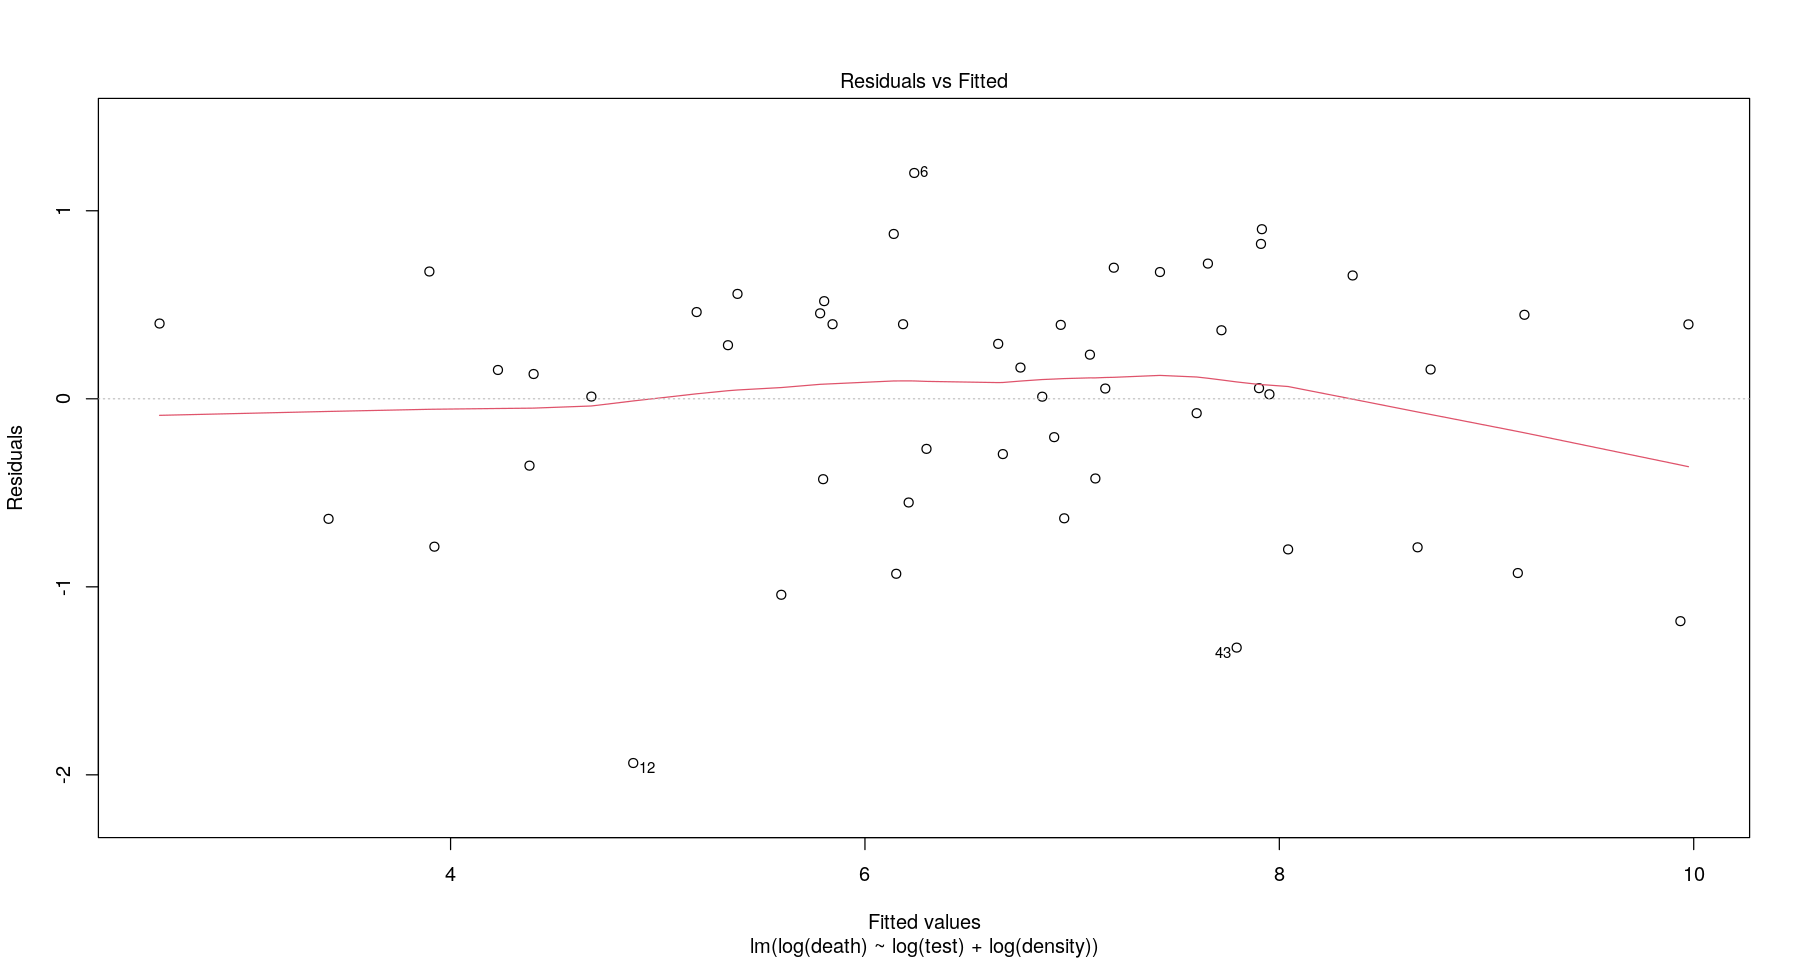

In [33]:
#residuals are much more positively skewed
plot(model23, which = 1)

To examine zero conditional mean, we are looking if the mean of the residuals change from left to right which means we look at the red spline line and would expect it to be flat and at 0 if the assumption is met. Looking at the plot, we see the line slightly rises moving from left to right, bu then dips down toward the end indicating that there may be a violation of the zero-conditional mean. However, accounting for noise, the line is still relatively flat.

#### Exogeneity

Explanatory variables that are correlated with the error term are called endogenous. Endogeneity is a violation of zero-conditional mean and implies the OLS coefficients are biased and inconsistent and we want exogeneity $Cov(x_j, u) = 0$ for all j coefficients

In [34]:
#for both variables
cov(log(test),model23$residuals)
cov(log(density),model23$residuals)

[1] 7.134376e-17

[1] 1.480586e-17

We see for both variables that the covariance with the residuals is extremely small and nearly 0 suggesting that exogeneity is met.

### Homoskedasticity

The error $u$ has the same variance given any values of the explanatory variables $Var(u_i| x_1, x_2,...,x_k)=\sigma^2$

Explanatory variable values must contain no information about variability of the error.

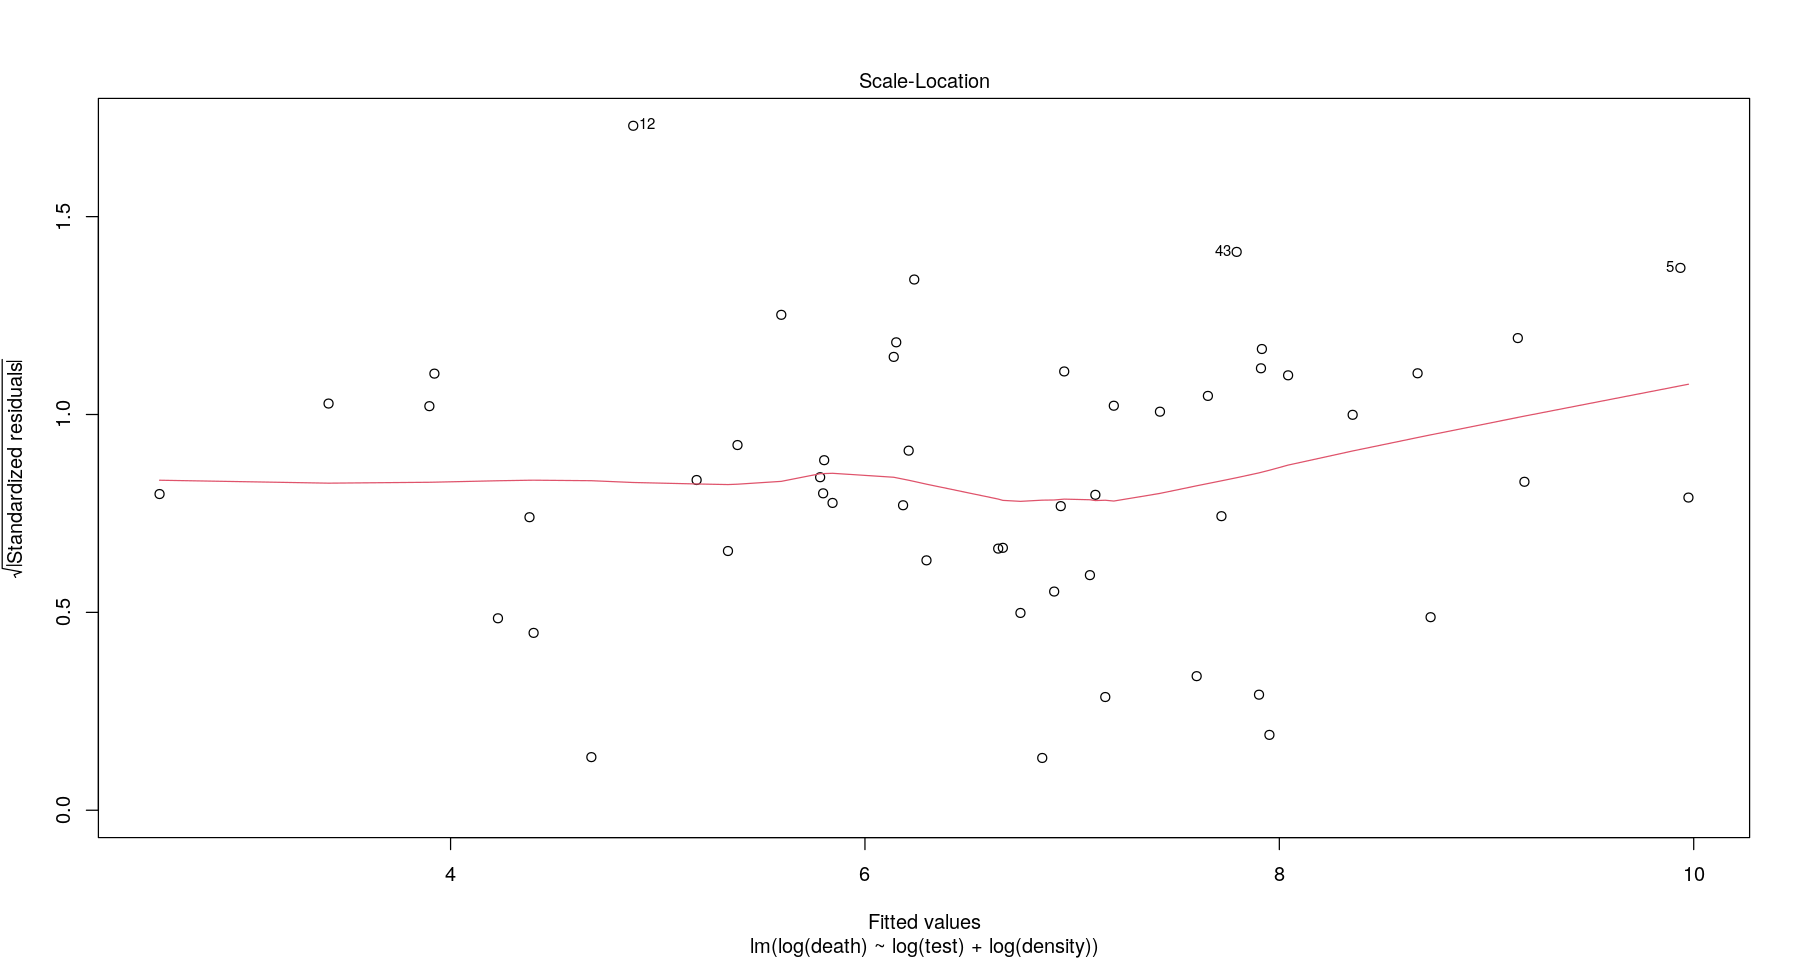

In [35]:
plot(model23, which=3)

The scale-location plot calculates the absolute value of the residuals and takes the root which reduces the skew moving points away from the x-axis and the homoskedastic errors should appear as a horizontal band showing the spread of variance has a generally uniform thickness if there is homoskedasticity. There seems to be heteroskedasticity since the band of points seems to increase in thickness towards the middle of the plot then become thinner towards the end points.

In [36]:
bptest(model23)
#Sample size matters greatly and we don't have too many so we can interpret these results to matter


	studentized Breusch-Pagan test

data:  model23
BP = 0.25016, df = 2, p-value = 0.8824


The null hypothesis of the Breusch-Pagan test is that there is homoskedasticity, and we have a p-value greater than 0.05 indicating we fail to reject the null hypothesis suggesting homoskedasticity is met.

### Normality

The population error $u$ is independent of the explanatory variables $x_1, x_2...,x_k$ and is normally distributed with zero mean and variance $\sigma^2$: $u$ is distributed as $N(0, \sigma^2)$. This assumption states that we assume the errors are drawn from a normal distribution with mean zero and also assume that the errors are independent of the explanatory variables, so the distribution looks the same conditional on any explanatory variable.

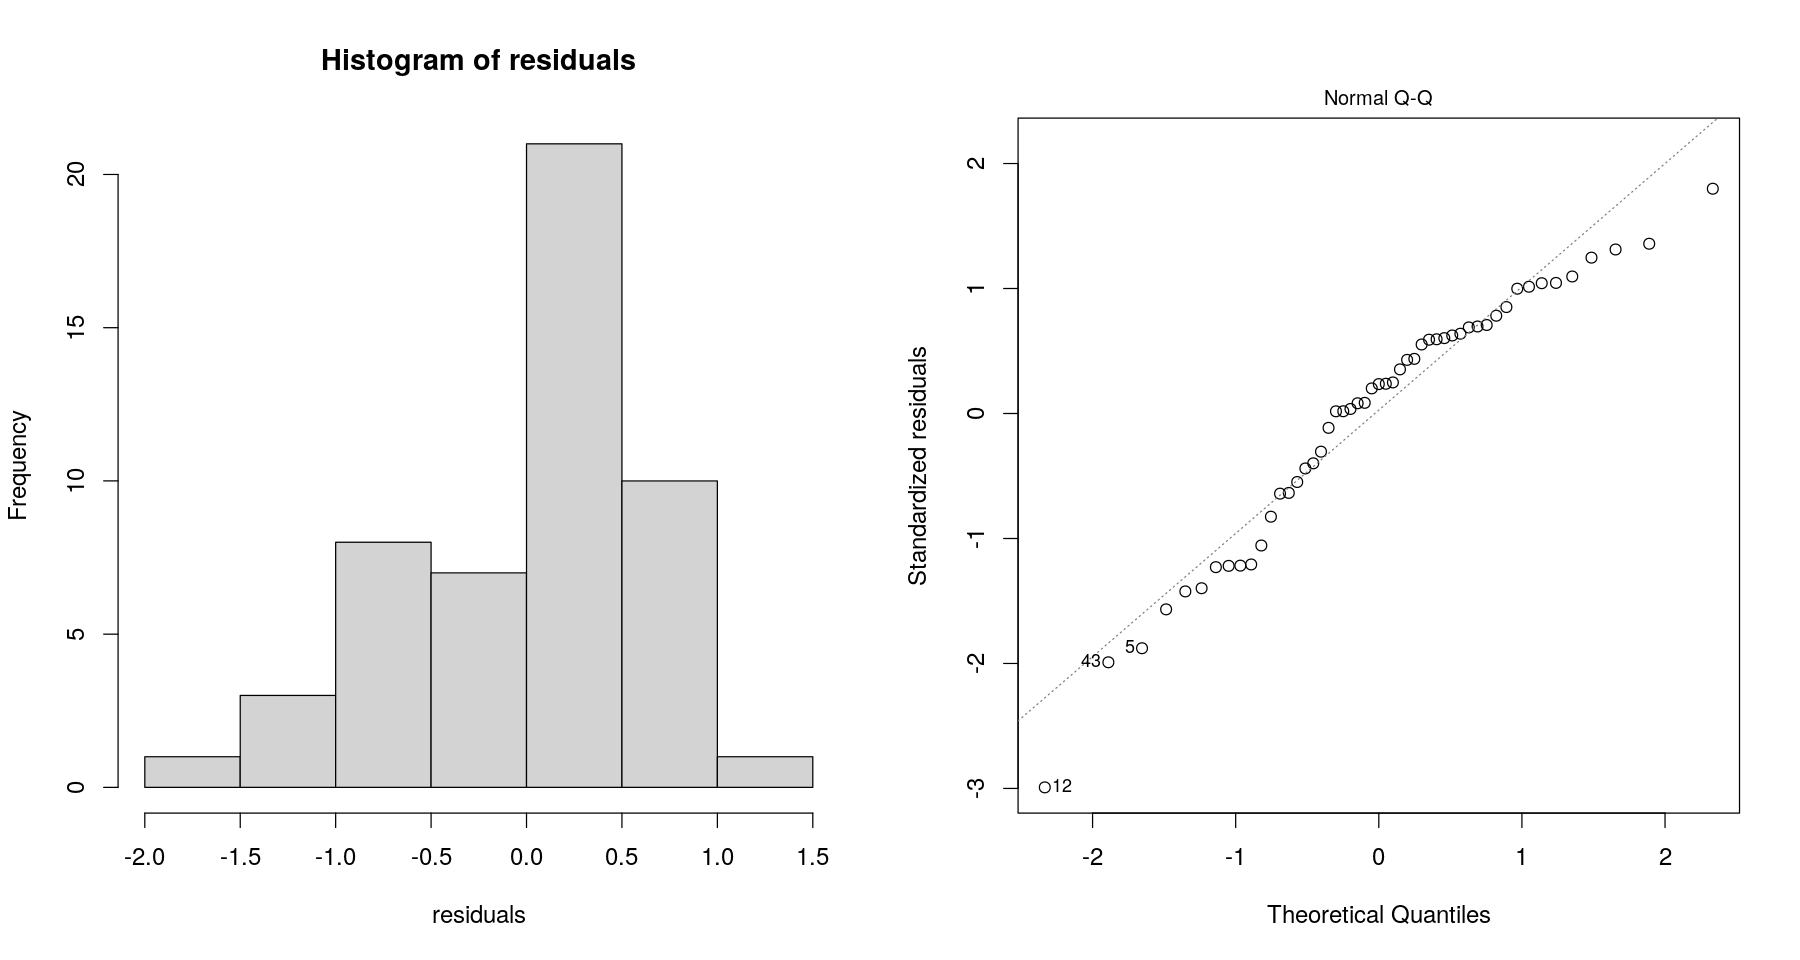

In [37]:
par(mfrow=c(1,2), cex = 1.2)

options(repr.plot.width=15, repr.plot.height=8)
hist(model23$residuals, main = "Histogram of residuals", xlab = 'residuals')

#for each data point, the y coordinate is the standardized residual
#(residual divided by the standard deviation of the residuals) and the x-coord) 
plot(model23, which = 2)

Looking at the above histogram of the residuals for the model, we see that the residuals seemingly follow a normal distribution that is slightly left-skewed. The Q-Q plot suggests that the majority of points fall close to the Q-Q line except for a few points to the right. Based on these plots, we see the normality assumption may be violated, but with the Central Limit Theorem (CLT), normality can be met. 

In [38]:
#normal hypothesis is that errors are normal
#huge dataset can show tiny deviations as significant, but we have a relatively small one still
shapiro.test(model23$residuals)


	Shapiro-Wilk normality test

data:  model23$residuals
W = 0.95568, p-value = 0.05464


The null hypothesis of the Shapiro-Wilk test that there is normality in the data. Our p-value is just greater than 0.05 indicating we fail to reject the null hypothesis suggesting that the distribution of the residuals is normal.

**Summary and Responses of Violations:**

1. **Zero conditional mean**

We are not making a causal model and instead just look for the best fit line. Exogeneity tells us that our estimates are consistent, so we can rely on exogeneity instead of the zero conditional mean.

2. **Homoskedasticity**

Despite the Breusch-Pagan test suggesting that homoskedasticity is met, we will still use robust standard errors to address heteroskedasticity for our model.

3. **Normality**

We have more than 30 samples in our data so we can use asymptotic property and one verison of the central limit theorem that says that OLS estimators are normally distributed for large sample sizes. Sampling distribution for coefficients can still be normally distributed relying on asymptotics.

## 4. A Regression Table

We use the log-model from each of the three specifications.

In [39]:
#Reference model 1 specification
model13


Call:
lm(formula = log(death) ~ log(test))

Coefficients:
(Intercept)    log(test)  
    -12.160        1.456  


In [40]:
#Reference model 2 specification
model23


Call:
lm(formula = log(death) ~ log(test) + log(density))

Coefficients:
 (Intercept)     log(test)  log(density)  
     -10.647         1.196         0.403  


In [41]:
#Reference model 3 specification
model32


Call:
lm(formula = log(death) ~ log(test) + log(density) + log(rate) + 
    log(cases) + pov + bus + child + young_ad + mil_ad + mid_ad + 
    old_ad + +log(unemp))

Coefficients:
 (Intercept)     log(test)  log(density)     log(rate)    log(cases)  
  -25.309652      0.709990      0.251447      0.848060      0.213930  
         pov           bus         child      young_ad        mil_ad  
   -0.006295      0.022931     15.639565      2.268874     13.615724  
      mid_ad        old_ad    log(unemp)  
   -6.977436     51.407762      0.479731  


In [42]:
####### Regression table analysis  #########
#Add the base model1,transformed model1, model2, model3
base = lm((death) ~ test)

se.base = sqrt(diag(vcovHC(base)))
se.model13 = sqrt(diag(vcovHC(model13)))
se.model23 = sqrt(diag(vcovHC(model23)))
se.model32 = sqrt(diag(vcovHC(model32)))

#Feed the models to the stargazer module with 
#cutoffs c(0.05, 0.01, 0.001)
# base model??
stargazer(model13, model23, model32, type = "text", 
          omit.stat = "f",
          se = list( se.model13, se.model23, se.model32),
          star.cutoffs = c(0.05, 0.01, 0.001),
         column.sep.width = "1pt")


                                  Dependent variable:              
                    -----------------------------------------------
                                      log(death)                   
                          (1)             (2)             (3)      
-------------------------------------------------------------------
log(test)              1.456***        1.196***        0.710***    
                        (0.134)         (0.142)         (0.191)    
                                                                   
log(density)                           0.403***         0.251**    
                                        (0.094)         (0.095)    
                                                                   
log(rate)                                              0.848***    
                                                        (0.184)    
                                                                   
log(cases)                                     

From the table, all variables in models 1 and 2 are highly statistically significance with p-values less than 0.001. In model 3, *test*, *density*, *rate*, *bus*, and *old_ad* are statistically significant. *test* and *rate* have p-values less than 0.001, while *density*, *bus*, and *old_ad* have p-values less than 0.01. The coefficients for these variables are all greater than double the standard error show in parentheses, so we know they are statistically significant. 

The adjusted R-squared for the three models is high meaning high effect sizes for each of these models of which model 3 shows the highest adjusted R-squared value compared to all the three models, indicating it can measure about 94% of variation between variables showing a strong effect size.

We can conclude from these models that *test* is the key variable that affects the deaths in statistically significant way according to model 1, model 2, and model 3. We also believe population density to be a key variable in explaining the number of deaths. Model 3 introduced a few new statistically significant variables like old age, rate of infection, and the importance of closing essential businesses in curbing deaths. However, model 3 also violated multicollinearity and we must keep this in mind.

In terms of practical significance, many believe that deaths come down as testing goes up. This inference is not true when pandemic is still spreading and the models support that.
From the given data, the models found that the rise in number of tests in the states is associated with an increase in the number of deaths due to covid significantly. This finding should not be ignored by the authorities, as rise in deaths means that the pandemic is spreading faster in the state. 
Thus, the authorities either legal or medical should be more vigil and alert as testing rate goes up and allocate budget on resources like (ventilators,ambulances, burial grounds) to contain deaths or take appropriate actions instead of thinking that they are testing more and that means the deaths are going to be lesser.

In [43]:
##### AIC score for model 1 vs model 2 vs model 3  #########
# Base models
cat("AIC score for base model1 is : ",AIC(model13))
cat("\nAIC score for base model2 is : ",AIC(model23))
cat("\nAIC score for base model3 is : ",AIC(model31))

# Best Transformed models
cat("\n\nAIC score for best transformed model1 is : ",AIC(model13))
cat("\nAIC score for best transformed model2 is : ",AIC(model23))
cat("\nAIC score for best transformed model3 is : ",AIC(model31))


AIC score for base model1 is :  133.1457
AIC score for base model2 is :  109.615
AIC score for base model3 is :  715.0181

AIC score for best transformed model1 is :  133.1457
AIC score for best transformed model2 is :  109.615
AIC score for best transformed model3 is :  715.0181

We use Akaike Information Criterion (AIC) to
evaluate the trade-off between goodness of fit and model parsimony for the three featured models. Generally, the interpretation is, the lower the AIC score the better the results.

From the analysis of AIC results, we found that model 2 has the lowest AIC score and model 3 has the highest. Although model 3 had a higher adjusted R-Squared value, model 2's adjusted R-Squared value was still significantly high (0.856). Based on these results, we believe that model 2 is the best model for the question as it balances goodness of fit and parsimony. 



## 5. A Discussion of Omitted Variables

We refer to our first model specification as the base for discussing omitted variables.

In [44]:
model13


Call:
lm(formula = log(death) ~ log(test))

Coefficients:
(Intercept)    log(test)  
    -12.160        1.456  


In [45]:
#Calculates the omitted variable bias
omitted_bias = function(dependent, explanatory, omitted){
    model_true = lm(dependent ~ explanatory + omitted)
    b1 = model_true$coefficients[3]
    first_stage = lm(omitted ~ explanatory)
    b2 = first_stage$coefficients[2]
    ovb = b1 * b2
    cat('Omitted Variable Bias =', ovb)
    cat('\nEstimate for Beta_1 when variable is omitted: ',ovb  + model_true$coefficients[2] )
    print(lm(dependent ~ explanatory))
}

### Days required to wear masks

Masks have been proven to be effective at curbing transmission rates when everyone wears them and as such the number of days that states have implemented mandatory public mask use may be an important omitted variable. We can use the *Mandate face mask use by employees in public-facing businesses* as a proxy variable to measure the number of days that states have mandated public mask use.

https://www.cdc.gov/media/releases/2020/p0714-americans-to-wear-masks.html 

In [46]:
omitted_bias(death, test, mask)

Omitted Variable Bias = 0.0001567587
Estimate for Beta_1 when variable is omitted:  0.004019359
Call:
lm(formula = dependent ~ explanatory)

Coefficients:
(Intercept)  explanatory  
 -2.593e+02    4.019e-03  



Given that the omitted variable bias is positive, the OLS estimates will over estimate the marginal effect of total tests on deaths. Furthermore, it will scale the coefficient away from zero making it easier to reject the null hypothesis/gain statistical significance. The value of the bias is very small (< 0.05), so the marginal effect is small and may just be an artifact of omitted variable bias.

### Elderly proportion

Older generations are more susceptible to serious infection and consequently death from COVID-19. Although we have the proportions of age groups, an important omitted variable may be the proportion of older generations as a single value instead of broken up. We use the *Adults 55-64* and *65+* variables to create this variable.

https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/older-adults.html 

In [47]:
omitted_bias(death, test, elderly)

Omitted Variable Bias = -0.0001135007
Estimate for Beta_1 when variable is omitted:  0.004020713
Call:
lm(formula = dependent ~ explanatory)

Coefficients:
(Intercept)  explanatory  
 -2.593e+02    4.019e-03  



Given that the omitted variable bias is negative, the OLS estimates will not over estimate the marginal effect of total tests on deaths. Furthermore, it will scale the coefficient toward zero making it harder to reject the null hypothesis/gain statistical significance. The value of the bias is very small (< 0.05), so the marginal effect is small and may just be an artifact of omitted variable bias.

### Obesity rate

$death = \beta_0 + \beta_1tests +\beta_2obesity + u$

$obesity = \alpha_0 +\alpha_1tests + v$

If $\beta_2 > 0$ and $\alpha_1 >0$ since obesity is at an risk factor for COVID-19 and obese people who catch COVID-19 can show signs of more severe symptoms and those who are obese may be more keen to testing, then $OMVB = \beta_2\alpha_1 >0$ and if $\beta_1>0$ then the OLS coefficient on $obesity$ will be scaled away from zero (more positive) gaining statistical significance.

We can assume the obesity rate and the number of tests are positively correlated since obesity is a risk factor and intuitively it makes sense that more tests would be carried out with a higher at risk population.

https://www.obesity.org/covid-19-and-obesity/

### Smoking rate


$death = \beta_0 + \beta_1tests +\beta_2smoking + u$

$smoking = \alpha_0 +\alpha_1tests + v$

If $\beta_2 > 0$ and $\alpha_1 >0$ since smoking is at an risk factor for COVID-19 and those who do smoke may be more keen to testing, then $OMVB = \beta_2\alpha_1 >0$ and if $\beta_1>0$ then the OLS coefficient on $smoking$ will be scaled away from zero (more positive) gaining statistical significance

https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html#smoking

### African American percentage
https://www.cnn.com/2020/05/05/health/coronavirus-african-americans-study/index.html

Social conditions, structural racism, lack of health care access,density of households,unemployment, pervasive discrimination
Counties with higher populations of black residents accounted for 52% of coronavirus diagnoses and 58% of Covid-19 deaths.

Using the dataset provided with the problem, we do not have any data that represents the demographics of a particular group of people. So, we estimate $\beta_1$ from simple regression of death on test.

$death = \beta_0 + \beta_1tests +\beta_2AfricanAmerican + u$

$AfricanAmerican = \alpha_0 +\alpha_1tests + v$

If $\beta_2 > 0$ and $\alpha_1 >0$ we can infer African American percentage *AfricanAmerican* and deaths have a positive relationship and African Americans may be more keen to testing, then $OMVB = \beta_2\alpha_1 >0$ and if $\beta_1>0$ then the OLS coefficient on $AfricanAmerican$ will be scaled away from zero (more positive) gaining statistical significance

### Pollution levels :
https://www.hsph.harvard.edu/news/hsph-in-the-news/air-pollution-linked-with-higher-covid-19-death-rates/

People with COVID-19 who live in U.S. regions with high levels of air pollution are more likely to die from the disease than people who live in less polluted areas, according to a new nationwide study from Harvard T.H. Chan School of Public Health.

PM2.5 = {level of fine particulate pollution}
Using the dataset provided with the problem, we do not have any data that represents the pollution levels of PM2.5 in any state. So, we estimate  𝛽1 from simple regression of death on test.

$death = \beta_0 + \beta_1tests +\beta_2PM2.5 + u$

$PM2.5 = \alpha_0 +\alpha_1tests + v$

If $\beta_2 > 0$ and $\alpha_1 >0$ we can infer the level of fine particulate pollution *PM2.5* and deaths have a positive relationship and those who live in more polluted areas may have an increased number of tests knowing it is a risk factor, then $OMVB = \beta_2\alpha_1 >0$ and if $\beta_1>0$ then the OLS coefficient on $PM2.5$ will be scaled away from zero (more positive) gaining statistical significance.

## 6. A Conclusion

Model 2 gave us consistently good results based on the R-squared and AIC score indicating a good balance between goodness of fit and parsimony with only two regressor variables. This model can be interpreted through percent changes and this type of transform makes sense for our purposes since percent changes in the number of deaths gives meaningful information on the spread and severity of COVID-19.

The first model specification using only the number of tests gave an adjusted R-squared value of 0.767 so about 76.7% of the variance was explained by the model. This is a high R-squared value indicating that tests alone is a good predictor for the number of deaths. Examining the model coefficients, we see that a 1% increase in the number of tests results in a 1.456% increase in the number of deaths. We note that this is not a causal model, but an associative one.

The second model had a higher adjusted R-squared of 0.856, which is higher than our first model after adding the population density. We also added the percent at risk, but found it was not statistically signficant and removing it did not change the R-squared. We see that the coefficient for the number of tests did not significantly change and that a 1% increase in the number of tests results in a 1.196% increase in the overall number of deaths. A 1% increase in the population density results in a 0.403% increase in the number of deaths. Both of these are highly statistically significant, and while the values are seemingly small, even a 0.403% increase in the number of deaths for a state can be a significant amount.

The third model had the highest adjusted R-squared value of 0.942, which is an extremely high value suggesting that the model captures nearly all the variance. The statistically significant variables were the number of tests, population density, rate per 100,000 people, days non-essential businesses were closed, and the old age percent demographic. This model only log transformed those variables that were not percentages due to interpretability reasons as it would not make sense to log transform a percentage. Practically speaking, a combination of these variables is shown to be a strong candidate to model the number of deaths, but this model also violated the multicollinearity assumption, and for parsimony reasons as well, we believe model 2 is a better model for our purposes and to address the question. It is important to note that the third model with all the additional variables had the highest AIC score suggesting that it is the worst representation compared to the other models.

Addressing the research question (**Do states with higher testing have more total deaths?**), we can say that states with higher testing do generally have more total deaths. The number of tests seems to be the most important factor in determining the number of deaths across states and that there is a positive correlation between the two. Population density is the second most important factor that we feel needs to be taken into account for states to address the number of deaths that could result.

States should still increase testing as this serves as an important factor in preparation. States with high population densities and testing capacities should enact social policies that reduce the chance of spread whether it be through quarantine or strict public guidelines. In doing so, states ensure the best public health practices and safety of their citizens.
